# **0. 패키지 로딩**

In [1]:
### 기본
import numpy as np
import pandas as pd
import os
import gc
import warnings

### 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # 동적 시각화

## 옵션 설정
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

### 시계열 분석 패키지(ACF, PACF)
import statsmodels.api as sm

# **1. 데이터 불러오기**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/train_preprocessed.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/test_preprocessed.csv')

In [4]:
train.head()

id        date  store_nbr                      family  sales  onpromotion  \
0   0  2013-01-01          1                  AUTOMOTIVE   0.00         0.00   
1   1  2013-01-01         41                     SEAFOOD   0.00         0.00   
2   2  2013-01-01         41  SCHOOL AND OFFICE SUPPLIES   0.00         0.00   
3   3  2013-01-01         41                     PRODUCE   0.00         0.00   
4   4  2013-01-01         41              PREPARED FOODS   0.00         0.00   

      city      state type  cluster  dcoilwtico  transactions   holiday  
0    Quito  Pichincha    D       13       93.14          0.00  National  
1  Machala     El Oro    D        4       93.14          0.00  National  
2  Machala     El Oro    D        4       93.14          0.00  National  
3  Machala     El Oro    D        4       93.14          0.00  National  
4  Machala     El Oro    D        4       93.14          0.00  National

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705087 entries, 0 to 2705086
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   float64
 6   city          object 
 7   state         object 
 8   type          object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  transactions  float64
 12  holiday       object 
dtypes: float64(4), int64(3), object(6)
memory usage: 268.3+ MB


In [6]:
test.head()

id        date  store_nbr      family  onpromotion   city      state  \
0  3000888  2017-08-16          1  AUTOMOTIVE            0  Quito  Pichincha   
1  3000889  2017-08-16          1   BABY CARE            0  Quito  Pichincha   
2  3000890  2017-08-16          1      BEAUTY            2  Quito  Pichincha   
3  3000891  2017-08-16          1   BEVERAGES           20  Quito  Pichincha   
4  3000892  2017-08-16          1       BOOKS            0  Quito  Pichincha   

  type  cluster  dcoilwtico  holiday  
0    D       13       46.80  Weekday  
1    D       13       46.80  Weekday  
2    D       13       46.80  Weekday  
3    D       13       46.80  Weekday  
4    D       13       46.80  Weekday

In [7]:
# date를 datetime 형으로 변경

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705087 entries, 0 to 2705086
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
 12  holiday       object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory usage: 268.3+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
 5   city         28512 non-null  object        
 6   state        28512 non-null  object        
 7   type         28512 non-null  object        
 8   cluster      28512 non-null  int64         
 9   dcoilwtico   28512 non-null  float64       
 10  holiday      28512 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 2.4+ MB


- 제대로 변경되었다.

## **📌 Data Description**
| Index | Column        | Description                     |
|-------|---------------|---------------------------------|
| 1     | id            | 각 데이터를 구분하기 위한 식별자|
| 2     | date          |판매일자                         |
| 3     | store_nbr     |매장 고유 식별번호               |
| 4     | family        |판매되는 제품군 유형             |
| 5     | sales         |매출액, **target 변수**        |
| 6     | onpromotion   |프로모션 대상 제품 수            |
| 7     | city          |도시                             |
| 8     | state         |주                               |
| 9     | type          |매장 유형                        |
| 10    | cluster       |유사한 매장들의 군집             |
| 11    | dcoilwtico    |유가(기름값)                     |
| 12    | transactions  |거래량                           |
| 13    | holiday       |공휴일 종류                      |



# **2. 시계열 분석**
- target 변수에 대한 시계열 분석을 진행해 보자.

In [10]:
### 시계열 분석 시에는 일별 평균값을 활용할 예정

# sales가 없는(0인) 데이터는 제외
train2 = train[train['sales'] != 0]

# 일별 평균 계산
daily_average = train2.groupby(['date'])['sales'].mean()

## **2-1. 시도표**

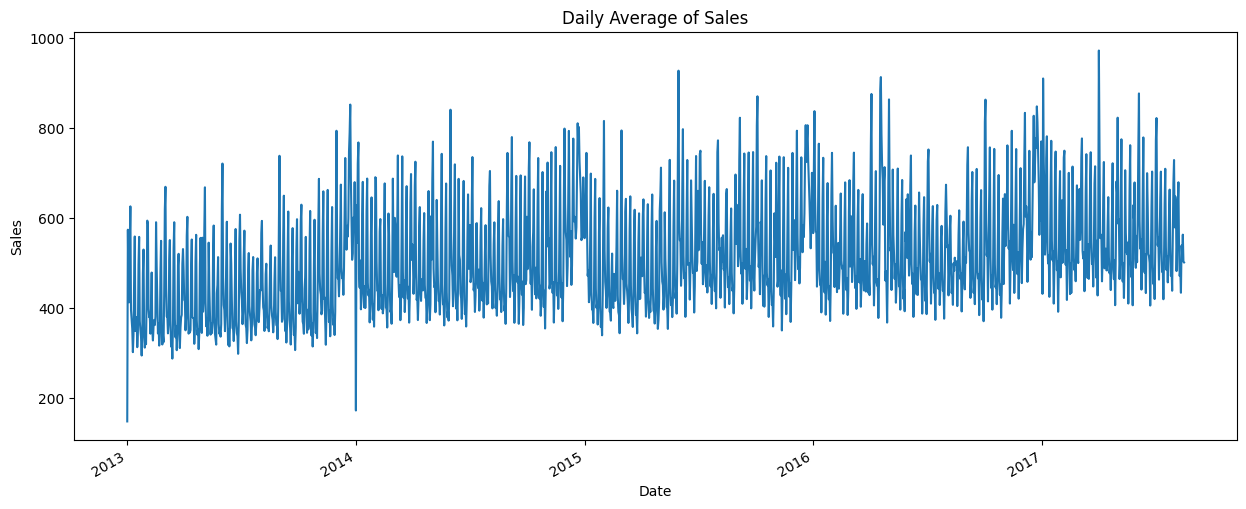

In [11]:
daily_average.plot(figsize = (15, 6))
plt.title('Daily Average of Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

- 중간중간 휴업으로 인한 불규칙성을 보임
- 특히 2013, 2014년 초에 급격한 매출 저하를 보이는 구간들이 존재

## **2-2. 시계열 분해(time series decomposition)**

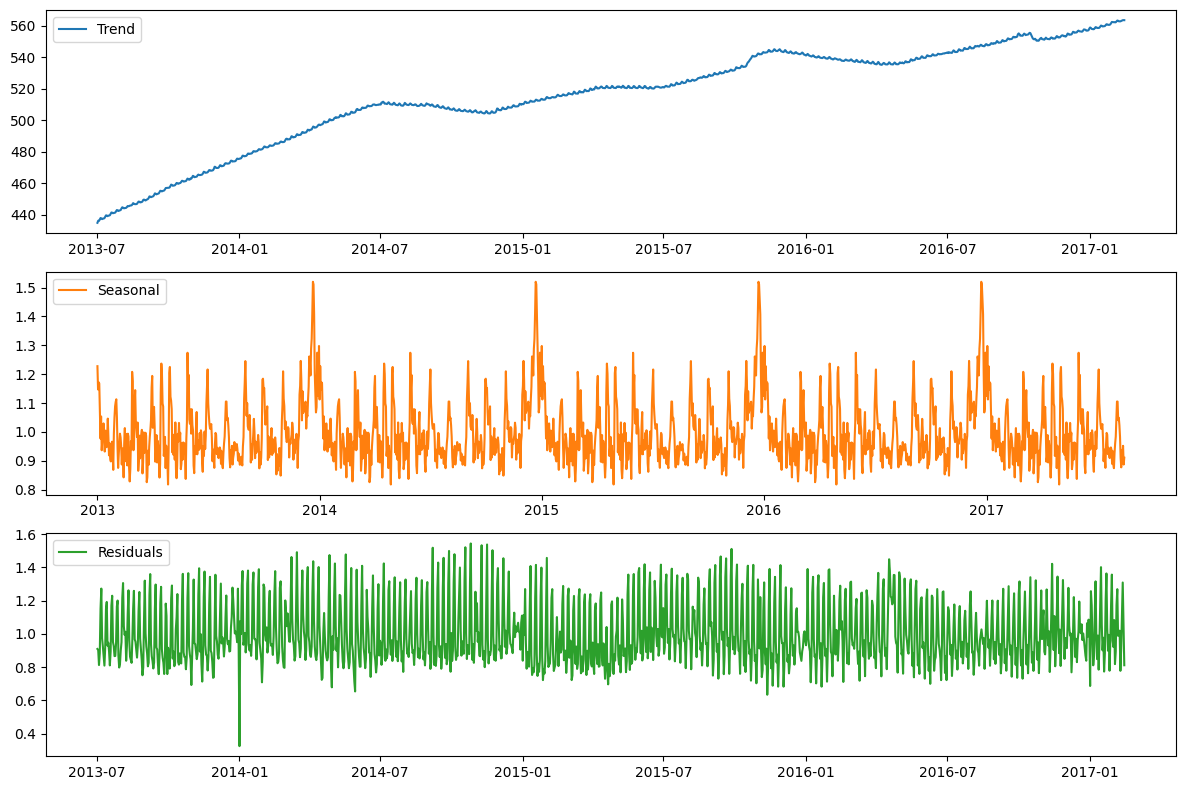

In [12]:
## 시계열 데이터 분해(연 단위로 분해)
result = sm.tsa.seasonal_decompose(daily_average, model='multiplicative', period=365)

# 색상 설정
colors = plt.cm.tab10.colors

# 시각화
plt.figure(figsize=(12, 8))

# 추세(Trend)
plt.subplot(3, 1, 1)
plt.plot(result.trend, label='Trend', color=colors[0])
plt.legend(loc='upper left')

# 계절성(Seasonality)
plt.subplot(3, 1, 2)
plt.plot(result.seasonal, label='Seasonal', color=colors[1])
plt.legend(loc='upper left')

# 잔차(Residuals) 분석
plt.subplot(3, 1, 3)
plt.plot(result.resid, label='Residuals', color=colors[2])
plt.legend(loc='upper left')

# 레이아웃 조정
plt.tight_layout()

# 시각화 표시
plt.show()

- 추세(Trend)
  - 우상향 추세를 보인다.
  > 향후에도 매출액이 증가할 것이라고 예측할 수 있다.

- 계절성(Seasonality)
  - 주로 연말(11~12월)에 매출이 증가하고 이후 감소한다.
  > 계절적 주기성이 존재한다.
  
- 잔차 분석
  - 잔차에 어떠한 패턴을 보이고 있지 않다.


## **2-3. 정상성(Stationarity)**

### **1️⃣ ACF, PACF**

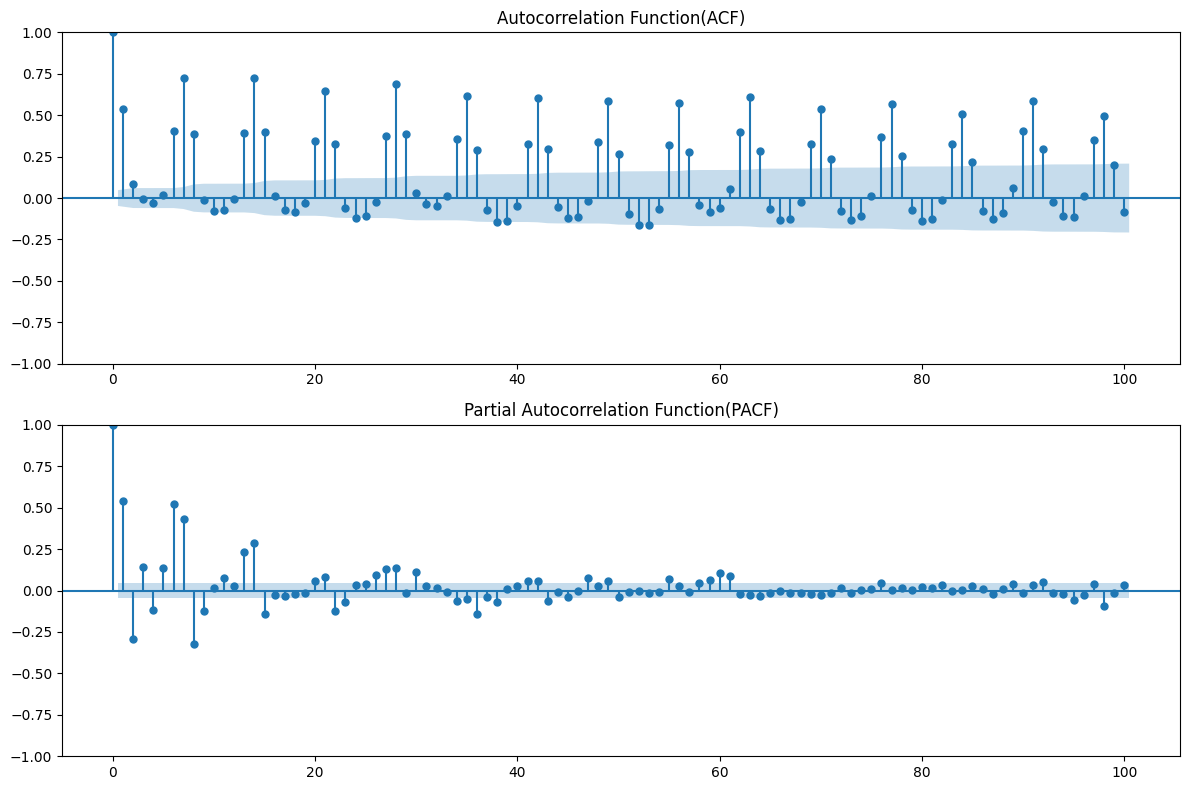

In [13]:
# ACF 및 PACF 계산 및 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF 시각화
sm.graphics.tsa.plot_acf(daily_average, lags=100, ax=axes[0])
axes[0].set_title('Autocorrelation Function(ACF)')

# PACF 시각화
sm.graphics.tsa.plot_pacf(daily_average, lags=100, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function(PACF)')

# 레이아웃 조정
plt.tight_layout()

# 시각화 표시
plt.show()

- ACF 그래프 시각화 결과 특정 패턴이 존재한다
  - 곡선의 형태를 가지며 점점 감소하는 형태

> 비정상 시계열이라고 짐작할 수 있다.

- PACF 그래프를 통해서는 별다른 특징을 파악하긴 어렵다.



### **2️⃣ ADF 검정(Augmented Dickey-Fuller Test)**
- 시계열 데이터의 안정성을 평가하는 통계적인 방법
  - 다음 가설을 검증하며, 귀무가설이 기각되면 해당 시계열은 안정적이라고 간주
    - 귀무가설(H0): 시계열 데이터는 단위근(Non-stationary)을 가진다.  
      (즉, 안정적이지 않다)
    - 대립가설(H1): 시계열 데이터는 안정적이다.

In [14]:
from statsmodels.tsa.stattools import adfuller

# ADF 검정 수행
result = adfuller(daily_average)

# 결과 출력
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -4.077050002235016
p-value: 0.001056669423237086


시계열 데이터는 안정적이다.

> 상충된 결과가 도출됨
> 시각적으로 너무나도 비정상 시계열의 특징을 띄고 있다.

**❓ 비정상성은 어떻게 해결하나?**
- 시계열 분석에서 정상성은 중요한 가정 중 하나
  - 통계적 추정의 안정성, 예측 성능 향상
- 주로 차분 등을 활용하여 정상성을 확보하고자 함

---
현재 우리는 2가지 문제점이 존재

1) 매장마다 개업 일자가 다름  
2) 중간에 휴업을 한 경우들도 존재  

> 차분의 어려움  
> 다른 파생 변수들을 통해 보완할 예정  


In [15]:
# 더 이상 일자가 연속될 필요가 없으므로 'sales'가 0인 데이터 삭제

train = train[train['sales'] != 0]

In [16]:
train[train['sales'] == 0]

Empty DataFrame
Columns: [id, date, store_nbr, family, sales, onpromotion, city, state, type, cluster, dcoilwtico, transactions, holiday]
Index: []

### **3️⃣ 시간 관련 변수**
- 시간적인 정보를 제공하기 위한 파생 변수들을 생성하자.

In [17]:
train['year'] = train['date'].dt.year # 연도
train['quarter'] = train['date'].dt.quarter # 분기별
train['month'] = train['date'].dt.month # 월
train['day_of_week'] = train['date'].dt.dayofweek # 요일

In [18]:
train.head()

id       date  store_nbr        family  sales  onpromotion     city  \
1427  1427 2013-01-01         25    GROCERY II  15.00         0.00  Salinas   
1428  1428 2013-01-01         25     GROCERY I 700.00         0.00  Salinas   
1429  1429 2013-01-01         25  FROZEN FOODS  29.65         0.00  Salinas   
1430  1430 2013-01-01         25          DELI  71.09         0.00  Salinas   
1431  1431 2013-01-01         25         DAIRY 143.00         0.00  Salinas   

            state type  cluster  dcoilwtico  transactions   holiday  year  \
1427  Santa Elena    D        1       93.14        770.00  National  2013   
1428  Santa Elena    D        1       93.14        770.00  National  2013   
1429  Santa Elena    D        1       93.14        770.00  National  2013   
1430  Santa Elena    D        1       93.14        770.00  National  2013   
1431  Santa Elena    D        1       93.14        770.00  National  2013   

      quarter  month  day_of_week  
1427        1      1            1  
1428        1      1            1  
1429        1      1            1  
1430        1      1            1  
1431        1      1            1

In [19]:
test['year'] = test['date'].dt.year # 연도
test['quarter'] = test['date'].dt.quarter # 분기별
test['month'] = test['date'].dt.month # 월
test['day_of_week'] = test['date'].dt.dayofweek # 요일

In [20]:
test.head()

id       date  store_nbr      family  onpromotion   city      state  \
0  3000888 2017-08-16          1  AUTOMOTIVE            0  Quito  Pichincha   
1  3000889 2017-08-16          1   BABY CARE            0  Quito  Pichincha   
2  3000890 2017-08-16          1      BEAUTY            2  Quito  Pichincha   
3  3000891 2017-08-16          1   BEVERAGES           20  Quito  Pichincha   
4  3000892 2017-08-16          1       BOOKS            0  Quito  Pichincha   

  type  cluster  dcoilwtico  holiday  year  quarter  month  day_of_week  
0    D       13       46.80  Weekday  2017        3      8            2  
1    D       13       46.80  Weekday  2017        3      8            2  
2    D       13       46.80  Weekday  2017        3      8            2  
3    D       13       46.80  Weekday  2017        3      8            2  
4    D       13       46.80  Weekday  2017        3      8            2

# **3. EDA**

## **3-1. type**
- type에 따라 store은 어떻게 구분될 것일까?

In [21]:
### type에 따른 매장 수

for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'store_nbr'].nunique()))

type A: 9
type B: 8
type C: 15
type D: 18
type E: 4


In [22]:
### type 별 제품군

for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'family'].nunique()))

type A: 32
type B: 32
type C: 32
type D: 33
type E: 32


In [23]:
### 타입별 주

for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'state'].unique()))

type A: ['Pichincha' 'Guayas' 'Tungurahua' 'Manabi']
type B: ['Guayas' 'Azuay' 'Pichincha' 'Los Rios' 'Santo Domingo de los Tsachilas']
type C: ['El Oro' 'Guayas' 'Manabi' 'Pichincha' 'Santo Domingo de los Tsachilas'
 'Imbabura' 'Bolivar' 'Cotopaxi' 'Los Rios' 'Chimborazo' 'Pastaza']
type D: ['Santa Elena' 'El Oro' 'Pichincha' 'Azuay' 'Loja'
 'Santo Domingo de los Tsachilas' 'Tungurahua' 'Guayas' 'Manabi']
type E: ['Esmeraldas' 'Guayas']


In [24]:
### 타입별 도시

for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'city'].unique()))

type A: ['Quito' 'Guayaquil' 'Ambato' 'Manta']
type B: ['Guayaquil' 'Cuenca' 'Quito' 'Cayambe' 'Babahoyo' 'Santo Domingo']
type C: ['Machala' 'Playas' 'El Carmen' 'Quito' 'Santo Domingo' 'Ibarra'
 'Guaranda' 'Latacunga' 'Quevedo' 'Riobamba' 'Guayaquil' 'Puyo']
type D: ['Salinas' 'Machala' 'Quito' 'Cuenca' 'Loja' 'Santo Domingo' 'Ambato'
 'Guayaquil' 'Daule' 'Manta']
type E: ['Esmeraldas' 'Guayaquil' 'Libertad']


In [25]:
### 타입별 cluster

for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'cluster'].unique()))

type A: [ 5 11 14 17]
type B: [ 6 16 10]
type C: [ 3 12 15  7]
type D: [ 1  4  9  2 13  8 10]
type E: [10]


## **3-2. cluster**

In [26]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'store_nbr'].nunique()))

cluster 1: 3
cluster 2: 2
cluster 3: 7
cluster 4: 3
cluster 5: 1
cluster 6: 6
cluster 7: 2
cluster 8: 3
cluster 9: 2
cluster 10: 6
cluster 11: 3
cluster 12: 1
cluster 13: 4
cluster 14: 4
cluster 15: 5
cluster 16: 1
cluster 17: 1


In [27]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'family'].nunique()))

cluster 1: 33
cluster 2: 33
cluster 3: 32
cluster 4: 33
cluster 5: 32
cluster 6: 32
cluster 7: 32
cluster 8: 33
cluster 9: 33
cluster 10: 33
cluster 11: 32
cluster 12: 32
cluster 13: 33
cluster 14: 32
cluster 15: 32
cluster 16: 32
cluster 17: 32


In [28]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'state'].unique()))

cluster 1: ['Santa Elena' 'Guayas']
cluster 2: ['Azuay']
cluster 3: ['El Oro' 'Guayas' 'Manabi' 'Santo Domingo de los Tsachilas' 'Los Rios']
cluster 4: ['El Oro' 'Loja' 'Santo Domingo de los Tsachilas']
cluster 5: ['Pichincha']
cluster 6: ['Guayas' 'Azuay' 'Pichincha' 'Santo Domingo de los Tsachilas']
cluster 7: ['Chimborazo' 'Pastaza']
cluster 8: ['Pichincha']
cluster 9: ['Pichincha' 'Tungurahua']
cluster 10: ['Esmeraldas' 'Guayas' 'Los Rios']
cluster 11: ['Pichincha' 'Manabi']
cluster 12: ['Pichincha']
cluster 13: ['Pichincha' 'Manabi']
cluster 14: ['Pichincha' 'Tungurahua']
cluster 15: ['Imbabura' 'Bolivar' 'Pichincha' 'Cotopaxi']
cluster 16: ['Pichincha']
cluster 17: ['Guayas']


In [29]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'city'].unique()))

cluster 1: ['Salinas' 'Guayaquil' 'Daule']
cluster 2: ['Cuenca']
cluster 3: ['Machala' 'Playas' 'El Carmen' 'Santo Domingo' 'Quevedo' 'Guayaquil']
cluster 4: ['Machala' 'Loja' 'Santo Domingo']
cluster 5: ['Quito']
cluster 6: ['Guayaquil' 'Cuenca' 'Quito' 'Cayambe' 'Santo Domingo']
cluster 7: ['Riobamba' 'Puyo']
cluster 8: ['Quito']
cluster 9: ['Quito' 'Ambato']
cluster 10: ['Esmeraldas' 'Guayaquil' 'Babahoyo' 'Libertad']
cluster 11: ['Quito' 'Manta']
cluster 12: ['Quito']
cluster 13: ['Quito' 'Manta']
cluster 14: ['Quito' 'Ambato']
cluster 15: ['Ibarra' 'Guaranda' 'Quito' 'Latacunga']
cluster 16: ['Quito']
cluster 17: ['Guayaquil']


In [30]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'type'].unique()))

cluster 1: ['D']
cluster 2: ['D']
cluster 3: ['C']
cluster 4: ['D']
cluster 5: ['A']
cluster 6: ['B']
cluster 7: ['C']
cluster 8: ['D']
cluster 9: ['D']
cluster 10: ['E' 'B' 'D']
cluster 11: ['A']
cluster 12: ['C']
cluster 13: ['D']
cluster 14: ['A']
cluster 15: ['C']
cluster 16: ['B']
cluster 17: ['A']


- `type`과 `cluster` 변수는 서로를 구분하는 데 중요한 역할을 하는 것으로 확인된다.

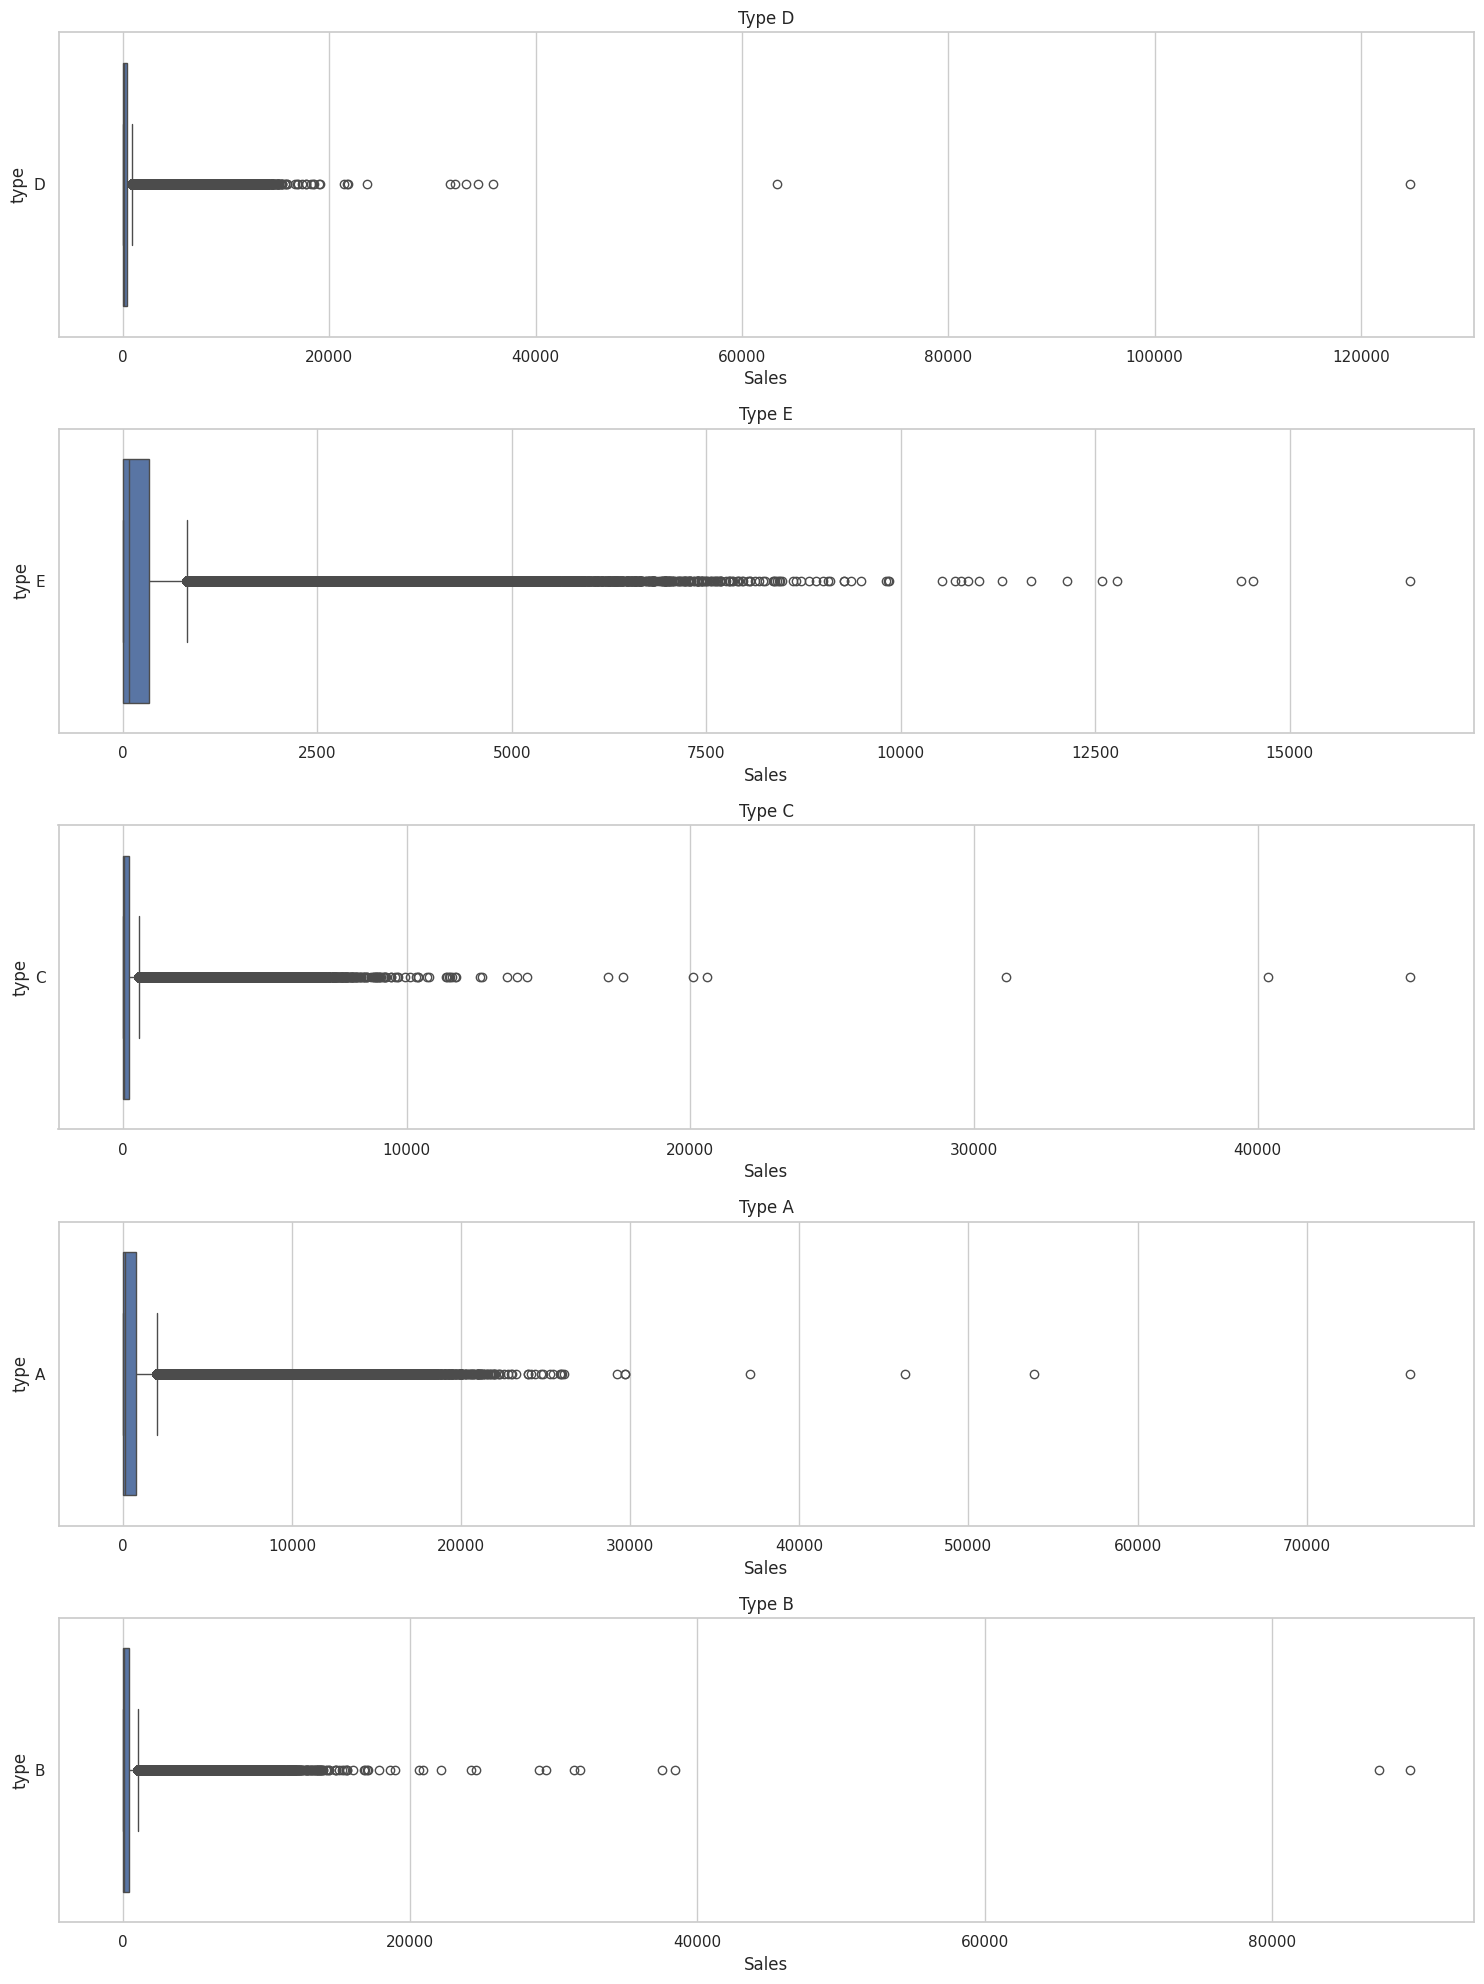

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))

# 각 type에 대한 상자 수염 그림을 해당 서브플롯에 그림
types = train['type'].unique()
for i, ax in enumerate(axes.flatten()):
    if i < len(types):
        sns.boxplot(x='sales', y='type', data=train[train['type'] == types[i]], ax=ax)
        ax.set_title(f'Type {types[i]}')
        ax.set(xlabel='Sales')

# 서브플롯 간의 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

- 매장 type별로 매출액에 큰 차이가 있음을 확인할 수 있다.
  - `type`에 따라 각각 다른 모델을 구축하기로 함

In [31]:
### 데이터를 type 별로 분리

typeA = train.loc[train['type'] == 'A', :]
typeB = train.loc[train['type'] == 'B', :]
typeC = train.loc[train['type'] == 'C', :]
typeD = train.loc[train['type'] == 'D', :]
typeE = train.loc[train['type'] == 'E', :]

In [32]:
### 데이터를 type 별로 분리

typeA_te = test.loc[test['type'] == 'A', :]
typeB_te = test.loc[test['type'] == 'B', :]
typeC_te = test.loc[test['type'] == 'C', :]
typeD_te = test.loc[test['type'] == 'D', :]
typeE_te = test.loc[test['type'] == 'E', :]

# **4. EDA(2)**
- type별로 분리하여 모델링을 진행해 보자.

## **4-1. Type A**

In [ ]:
typeA = typeA.drop('type', axis = 1) # 더 이상 type 변수는 필요 없으므로 삭제
typeA_te = typeA_te.drop('type', axis = 1) # 더 이상 type 변수는 필요 없으므로 삭제

In [ ]:
typeA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435786 entries, 76 to 2704223
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            435786 non-null  int64         
 1   date          435786 non-null  datetime64[ns]
 2   store_nbr     435786 non-null  int64         
 3   family        435786 non-null  object        
 4   sales         435786 non-null  float64       
 5   onpromotion   435786 non-null  float64       
 6   city          435786 non-null  object        
 7   state         435786 non-null  object        
 8   cluster       435786 non-null  int64         
 9   dcoilwtico    435786 non-null  float64       
 10  transactions  435274 non-null  float64       
 11  holiday       435786 non-null  object        
 12  year          435786 non-null  int64         
 13  quarter       435786 non-null  int64         
 14  month         435786 non-null  int64         
 15  day_of_week   4

In [ ]:
# 수치형 변수들의 기초통계량 확인

typeA[['sales', 'onpromotion', 'dcoilwtico', 'transactions']].describe()

sales  onpromotion  dcoilwtico  transactions
count 435786.00    435786.00   435786.00     435274.00
mean     810.13         3.45       67.70       3176.44
std     2006.72        14.80       25.64       1061.31
min        0.00         0.00       26.19          0.00
25%        4.00         0.00       46.32       2404.00
50%       50.06         0.00       53.21       3130.00
75%      592.89         1.00       95.70       3866.00
max    76090.00       252.00      110.62       8359.00

- target 변수인 `sales`는 굉장히 왜곡된 분포를 보이고 있다.
  - `np.log1p()`를 통한 로그 변환 수행 후 모델링하면 좋을 듯하다.
- `onpromotion` 변수의 경우 심하게 왜곡된 분포를 가지고 있음
  - 상관관계를 보고 전처리 유무를 결정하자.


### **🧡 store_nbr**

In [ ]:
# 고유한 매장 수

typeA['store_nbr'].unique()

array([45, 44, 46, 48, 49, 47, 51, 50, 52])

In [ ]:
### 각 매장별 매출 총액 시도표(일 단위)

a = typeA.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores_Type A")

- 각 매장마다 매출이 상이한 것을 확인할 수 있다.
- 45번 매장의 경우 매출액이 다른 매장에 비해 큰 것을 확인할 수 있다.
- 52번 매장의 경우 비교적 최근에 개장한 점을 확인할 수 있다.
> 모델링 시 매장 번호를 one-hot encoding 후 반영하는 것이 좋을 것이라고 판단됨

### **💛 family**

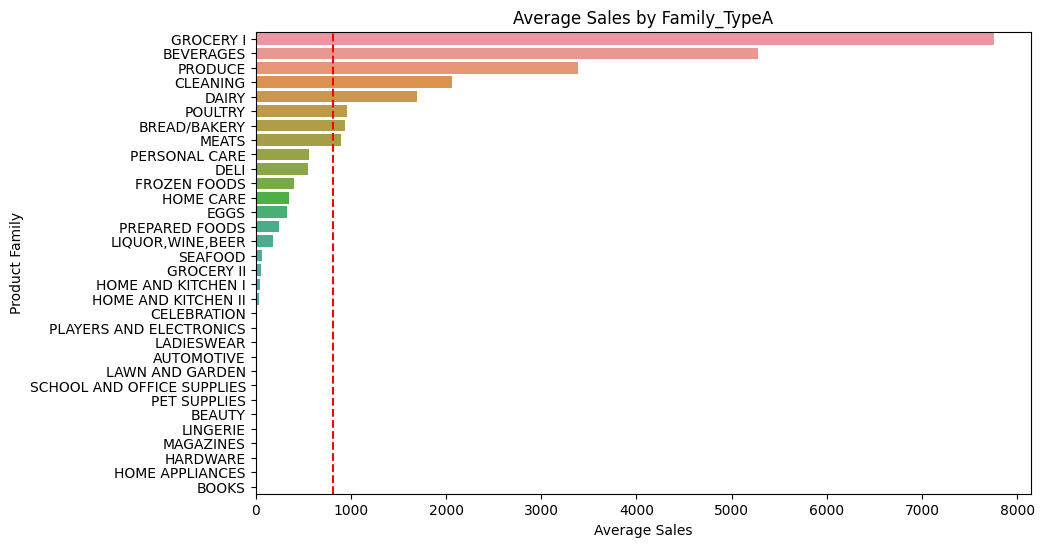

In [ ]:
### 각 품목별로 매출에 미치는 영향

# 각 family 별로 'sales'의 평균을 계산하고, 내림차순으로 정렬
average_sales_by_family = typeA.groupby('family')['sales'].mean().sort_values(ascending=False)

## 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='sales', y='family', data=typeA, order=average_sales_by_family.index, ci=None)
plt.axvline(x=typeA['sales'].mean(), color='red', linestyle='--') # 매출 전체 평균

# 그래프 제목 및 레이블 설정
plt.title('Average Sales by Family_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('Product Family')
plt.show()

- groceryI과 beverage가 매출의 대부분을 차지한다.
> 모델링 시 제품군을 one-hot encoding 후 반영하는 것이 좋을 것이라고 판단됨

### **💚 onpromotion**

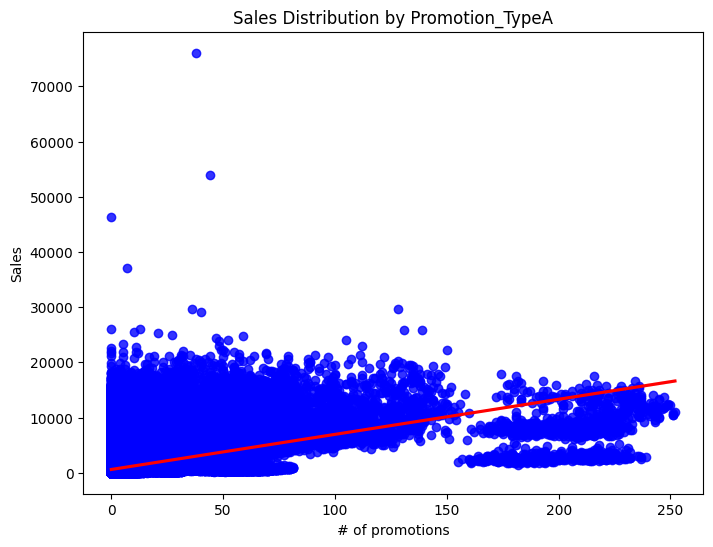

In [ ]:
plt.figure(figsize=(8, 6))

sns.regplot(x='onpromotion', y='sales', data=typeA, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Promotion_TypeA')
plt.xlabel('# of promotions')
plt.ylabel('Sales')
plt.show()

- 약한 양의 상관관계를 보인다.
- promotion되는 제품 수와 상관 없이 매출액이 큰 경우들이 존재함을 확인할 수 있다.

### **💙 state**

In [ ]:
# 고유한 주(state) 수

typeA['state'].unique()

array(['Pichincha', 'Guayas', 'Tungurahua', 'Manabi'], dtype=object)

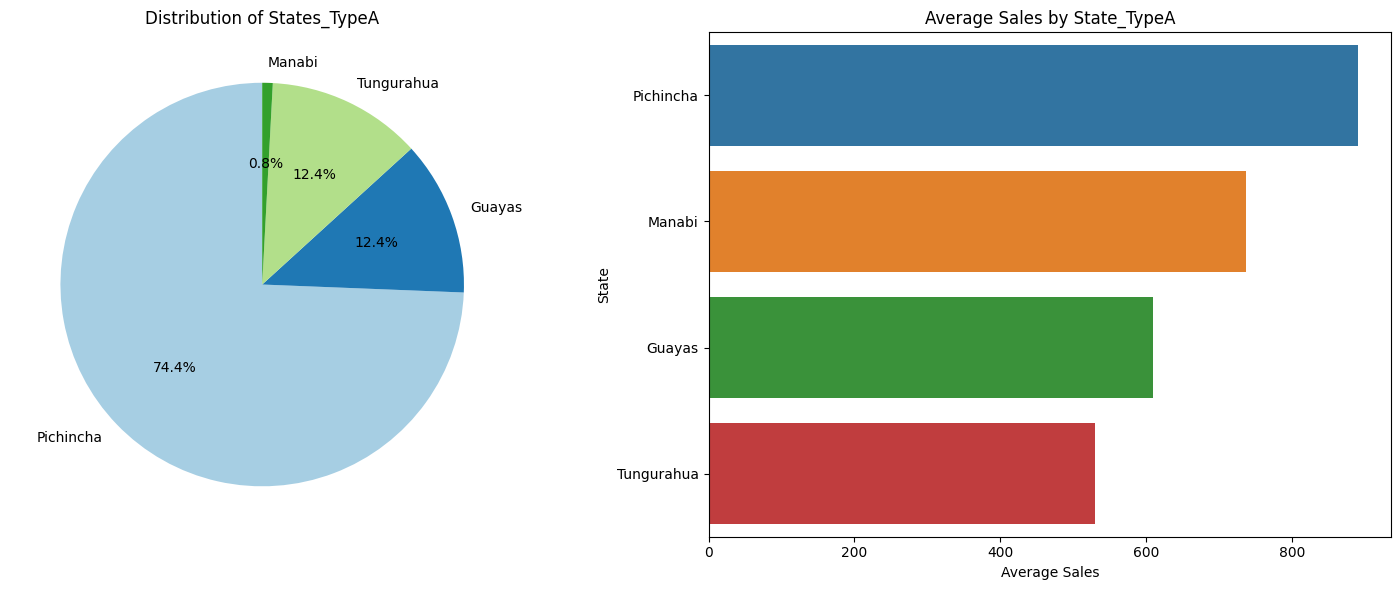

In [ ]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
state_counts = typeA['state'].value_counts()
plt.pie(state_counts, labels=state_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of States_TypeA')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_state = typeA.groupby('state')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='state', data=typeA, order=average_sales_by_state.index, ci=None)

plt.title('Average Sales by State_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('State')
plt.tight_layout()
plt.show()

- 주마다 매출액에 차이가 있음을 확인할 수 있다.
- Manabi 주의 경우 굉장히 적은 데이터 건수임에도 불구하고 매출에 큰 영향을 미침을 확인할 수 있다.

### **💜 city**

In [ ]:
# 고유한 도시(city) 수

print(typeA.groupby('state')['store_nbr'].unique())
print()
print(typeA.groupby('state')['city'].unique())

state
Guayas                            [51]
Manabi                            [52]
Pichincha     [45, 44, 46, 48, 49, 47]
Tungurahua                        [50]
Name: store_nbr, dtype: object

state
Guayas        [Guayaquil]
Manabi            [Manta]
Pichincha         [Quito]
Tungurahua       [Ambato]
Name: city, dtype: object


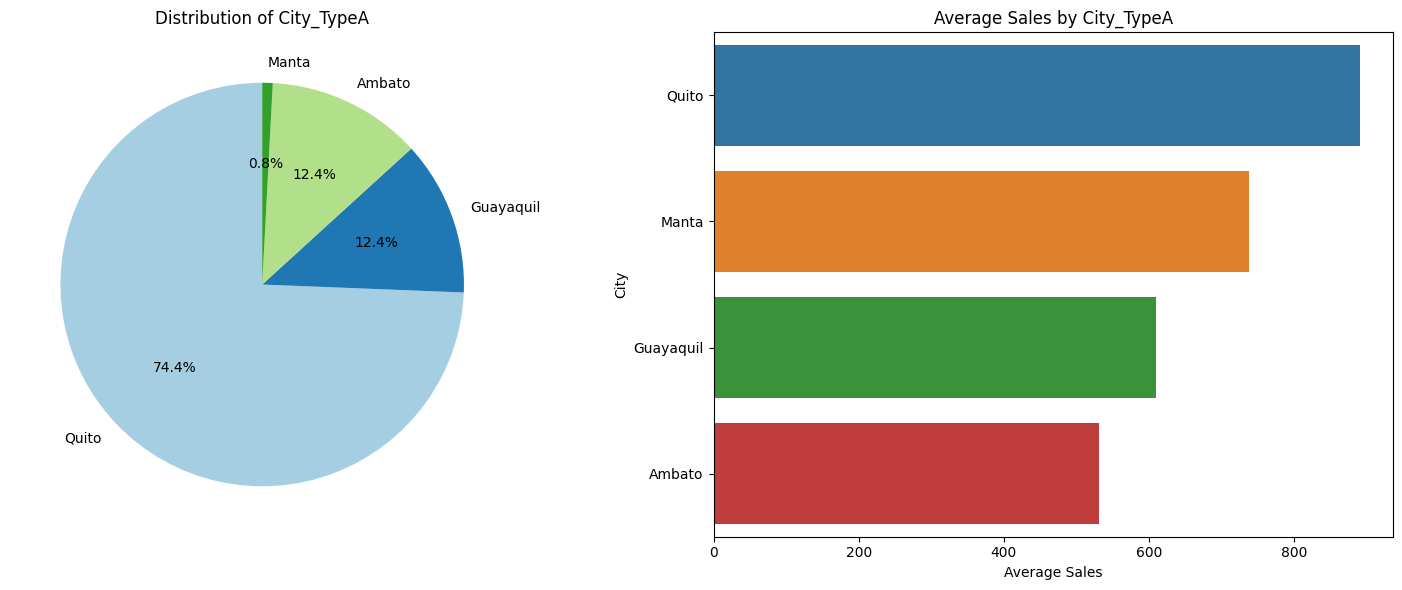

In [ ]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
city_counts = typeA['city'].value_counts()
plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of City_TypeA')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_city = typeA.groupby('city')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='city', data=typeA, order=average_sales_by_city.index, ci=None)

plt.title('Average Sales by City_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.tight_layout()
plt.show()

- `state`를 통해 `city`가 다 구분되는 상황
  - `sales`의 양상이 `state`와 유사
  - `state` 변수 하나만 남기기로 결정

### **🤎dcoilwtico**

In [ ]:
import plotly.express as px

daily_oil_price = typeA.groupby("date")["dcoilwtico"].mean().reset_index()

# 그래프 그리기
fig = px.line(daily_oil_price, x="date", y="dcoilwtico", title="Daily DcoilWTICO Prices")
fig.show()

- 유가 변동 경향과 sales의 변동이 별 상관은 없어 보인다.(추세가 다름)
- 2014년을 기점으로 급격하게 감소하는 추세를 보인다.
  - 그에 비해 매출은 그렇게 오르지 않았다.

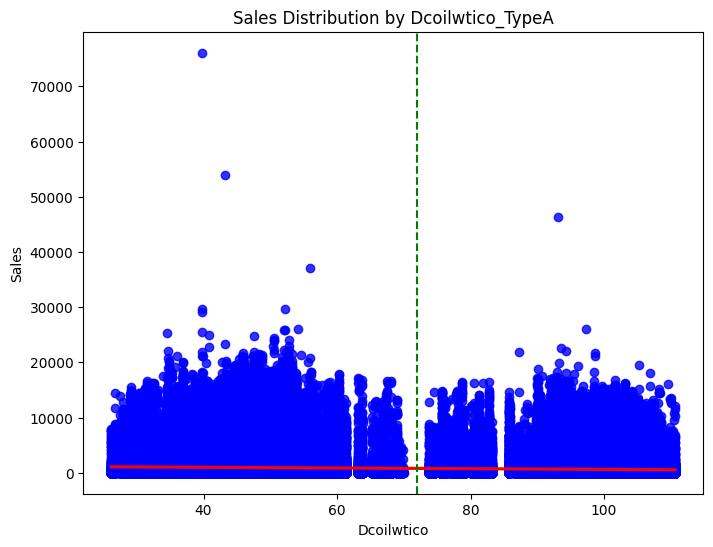

In [ ]:
plt.figure(figsize=(8, 6))

sns.regplot(x='dcoilwtico', y='sales', data=typeA, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.axvline(x=72, color='green', linestyle='--') # 72 구분선

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Dcoilwtico_TypeA')
plt.xlabel('Dcoilwtico')
plt.ylabel('Sales')
plt.show()

- 정말 별 상관은 없어 보인다.
- 다만 유가가 **72** 전후에서 두 개의 그룹으로 확연히 분리되는 것을 확인할 수 있다.

In [ ]:
under72 = typeA.loc[typeA['dcoilwtico'] <= 72,:]
over72 = typeA.loc[typeA['dcoilwtico'] > 72,:]

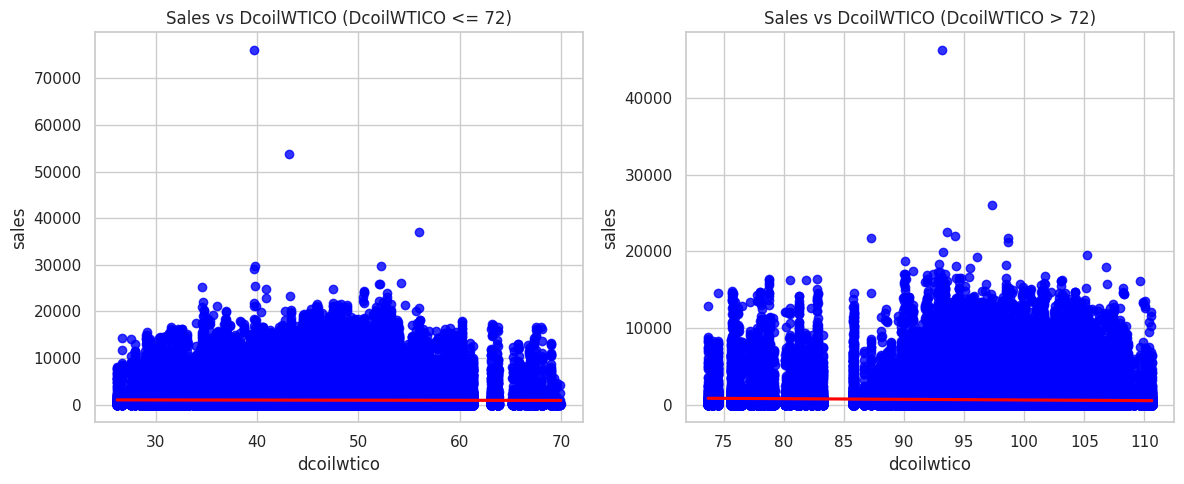

In [ ]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot regplot for 'dcoilwtico' <= 72
sns.regplot(x='dcoilwtico', y='sales', data=under72, ax=axes[0], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
axes[0].set_title('Sales vs DcoilWTICO (DcoilWTICO <= 72)')

# Plot regplot for 'dcoilwtico' > 72
sns.regplot(x='dcoilwtico', y='sales', data=over72, ax=axes[1], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
axes[1].set_title('Sales vs DcoilWTICO (DcoilWTICO > 72)')

# Adjust layout
plt.tight_layout()
plt.show()

- 차이가 나타나진 않는다..

### **💗 transactions**

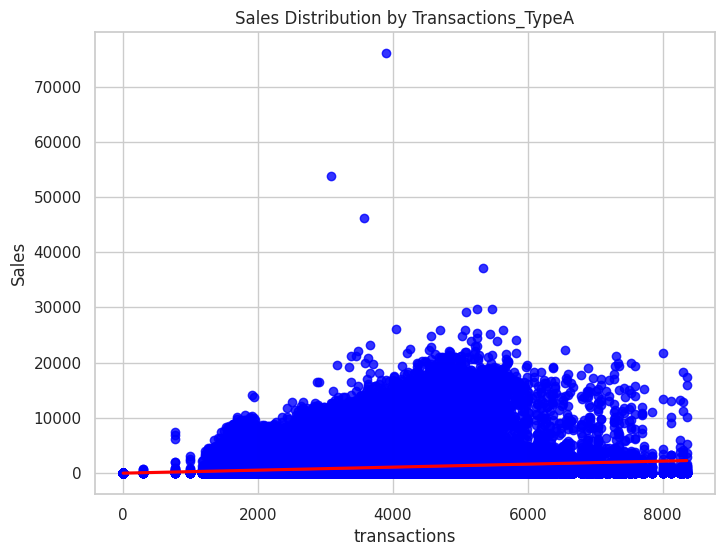

In [ ]:
plt.figure(figsize=(8, 6))

sns.regplot(x='transactions', y='sales', data=typeA, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Transactions_TypeA')
plt.xlabel('transactions')
plt.ylabel('Sales')
plt.show()

- 약한 양의 상관관계를 보인다.
- 그닥 상관은 없어 보인다.  
(어짜피 모델링 시 활용하기 어려움..)

### **🤍 holiday**

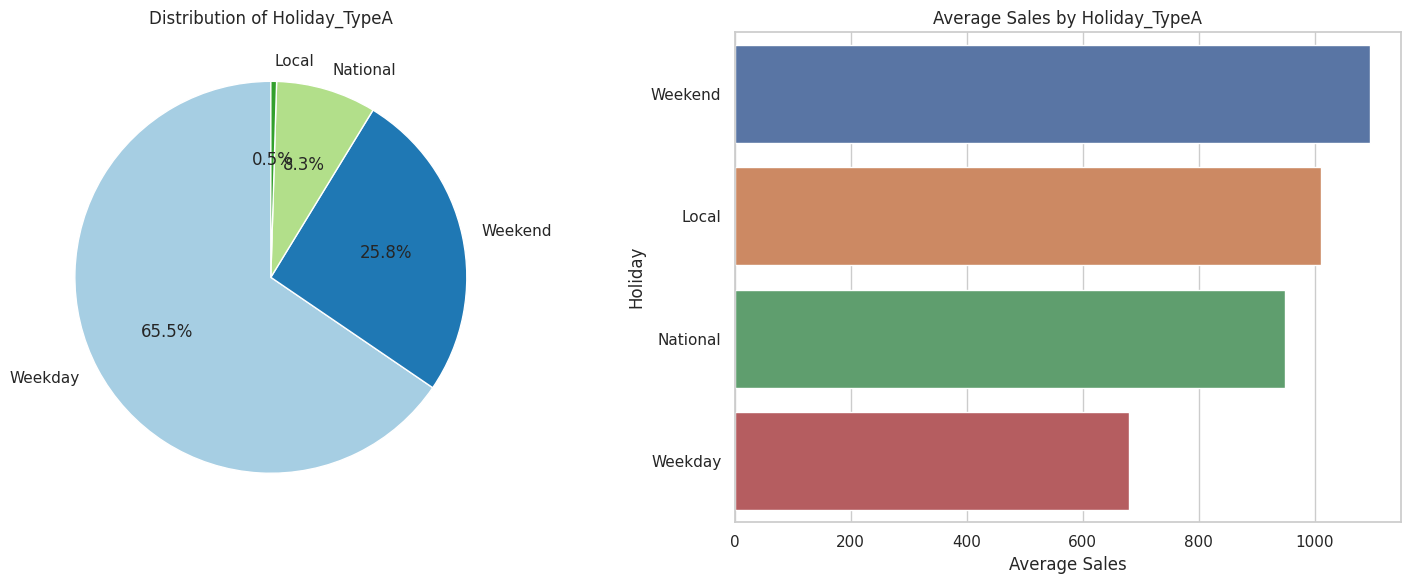

In [ ]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
holiday_counts = typeA['holiday'].value_counts()
plt.pie(holiday_counts, labels=holiday_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Holiday_TypeA')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_holiday = typeA.groupby('holiday')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='holiday', data=typeA, order=average_sales_by_holiday.index, ci=None)

plt.title('Average Sales by Holiday_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('Holiday')
plt.tight_layout()
plt.show()

- 그냥 주말(공휴일은 제외됨)에 매출이 가장 좋다.

### **⭐Target 변수(Sales)**
- 여러 요인에 따라 매출이 어떻게 달라지는지 살펴보자.

#### **a) 시간 관련 변수**

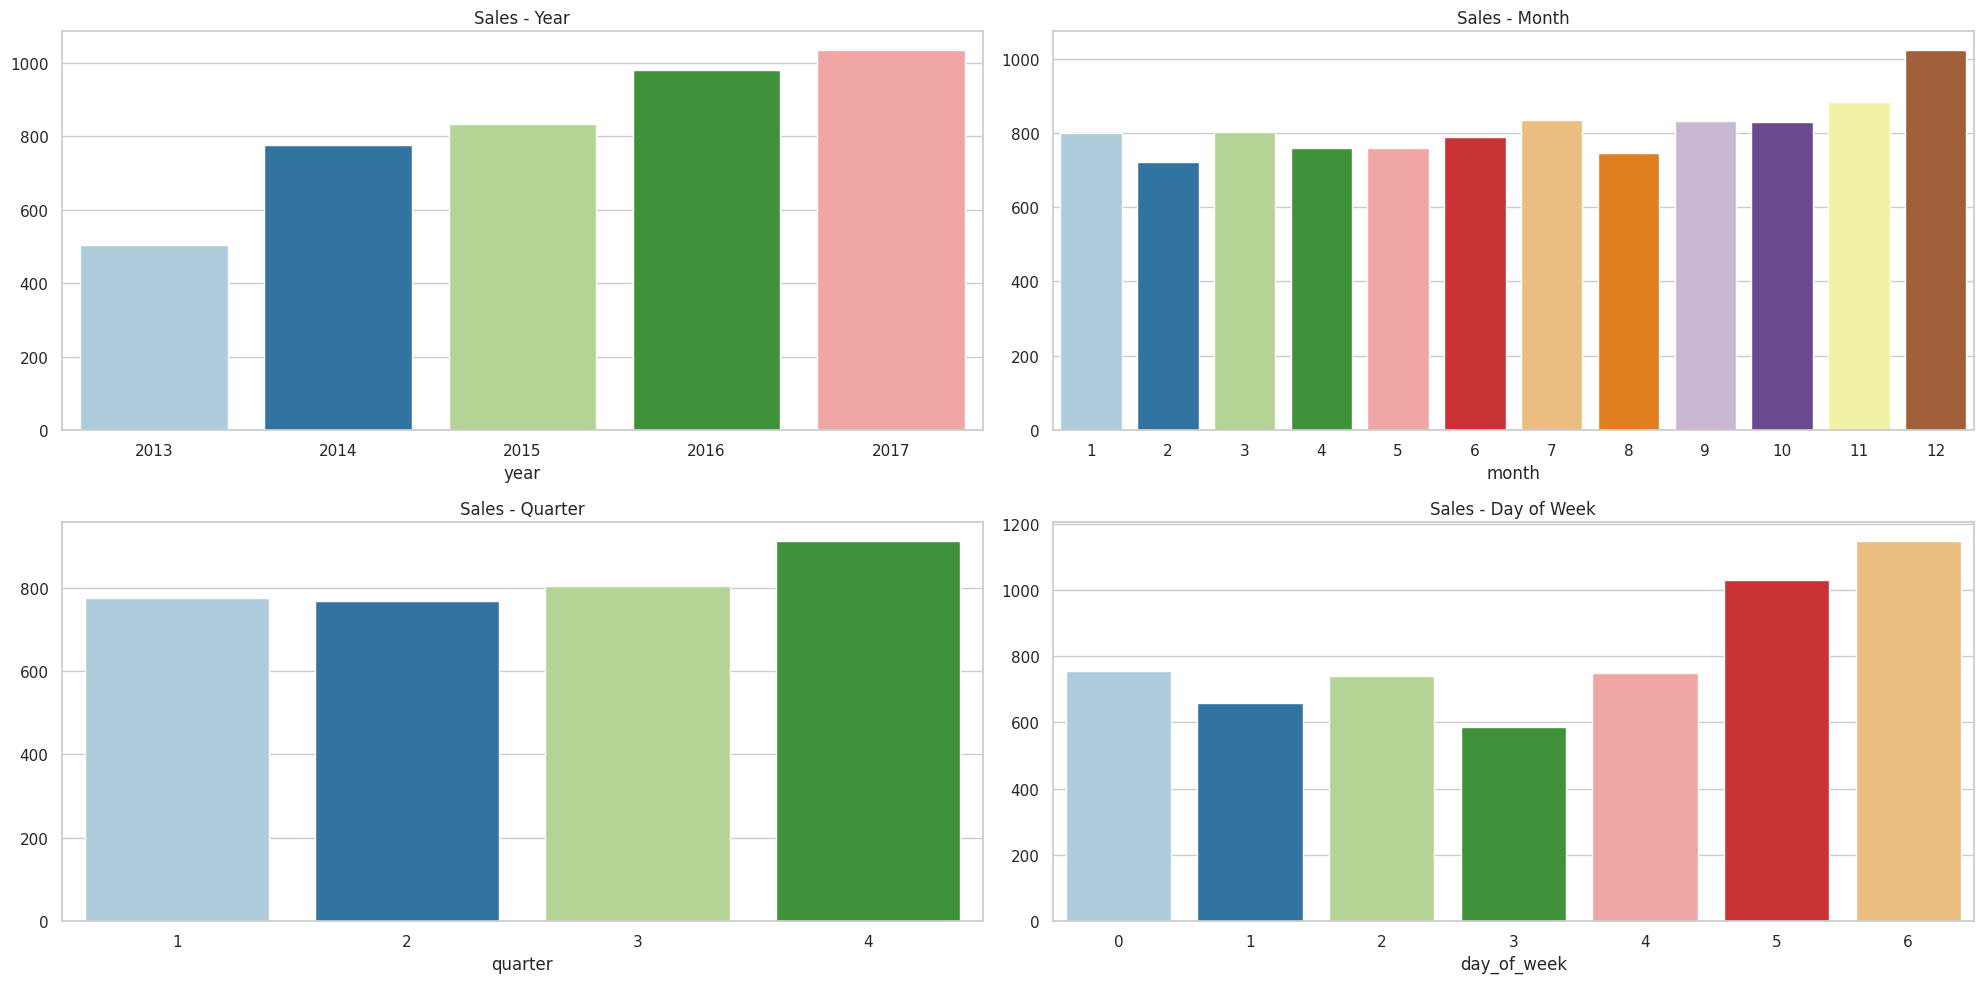

In [ ]:
### 평균 매출액으로 시각화
data_grouped_year = typeA.groupby(['year']).mean()['sales']
data_grouped_month = typeA.groupby(['month']).mean()['sales']
data_grouped_quarter = typeA.groupby(['quarter']).mean()['sales']
data_grouped_day = typeA.groupby(['day_of_week']).mean()['sales']

palette = sns.color_palette("Paired")

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
# 연도별 매출
axes[0, 0].set_title('Sales - Year')
sns.barplot(x=data_grouped_year.index, y=data_grouped_year.values, ax=axes[0, 0], palette=palette)
# 월별 매출
axes[0, 1].set_title('Sales - Month')
sns.barplot(x=data_grouped_month.index, y=data_grouped_month.values, ax=axes[0, 1], palette=palette)
# 분기별 매출
axes[1, 0].set_title('Sales - Quarter')
sns.barplot(x=data_grouped_quarter.index, y=data_grouped_quarter.values, ax=axes[1, 0], palette=palette)
# 요일별 매출
axes[1, 1].set_title('Sales - Day of Week')
sns.barplot(x=data_grouped_day.index, y=data_grouped_day.values, ax=axes[1, 1], palette=palette)

plt.tight_layout()
plt.show()

**연도별 매출**
- 뒤로 갈수록 매출액이 점점 증가하고 있다.

**월별 & 분기별 매출**  
- 대체로 비슷한 경향을 보이나, 12월에 매출이 증가
- 4분기에 매출 증가

**요일별 매출**  
- 평일에 비해 주말의 매출액이 더 높다.

#### **b) 변수들 간의 상관관계**
- 상관계수는 수치형 변수들끼리만 비교 가능

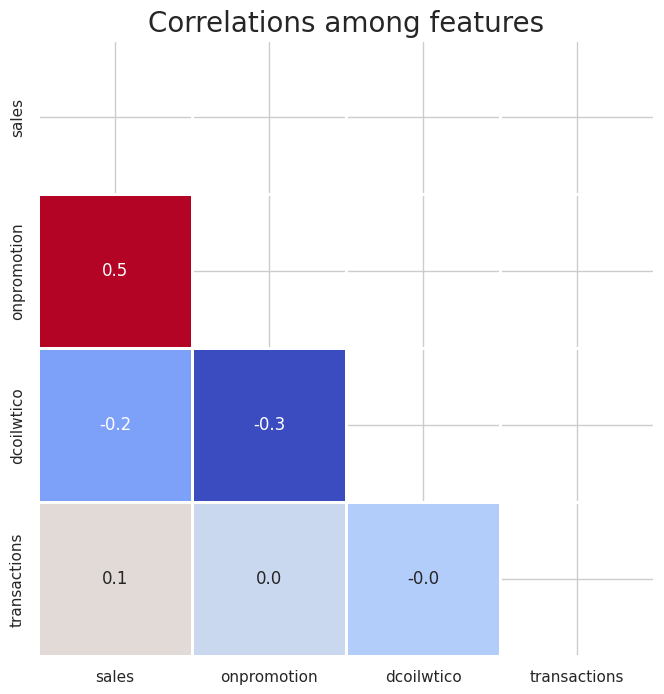

In [ ]:
num_ftrs = typeA[['sales', 'onpromotion','dcoilwtico','transactions']]

mask = np.triu(num_ftrs.corr(method = 'spearman'))

# heatmap을 이용한 시각화
plt.figure(figsize=(8, 8))
sns.heatmap(num_ftrs.corr(method = 'spearman'),
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)
plt.title("Correlations among features", fontsize=20)
plt.show()

### **💡 후처리**

#### **최종 변수 선택**

In [ ]:
typeA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435786 entries, 76 to 2704223
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            435786 non-null  int64         
 1   date          435786 non-null  datetime64[ns]
 2   store_nbr     435786 non-null  int64         
 3   family        435786 non-null  object        
 4   sales         435786 non-null  float64       
 5   onpromotion   435786 non-null  float64       
 6   city          435786 non-null  object        
 7   state         435786 non-null  object        
 8   cluster       435786 non-null  int64         
 9   dcoilwtico    435786 non-null  float64       
 10  transactions  435274 non-null  float64       
 11  holiday       435786 non-null  object        
 12  year          435786 non-null  int64         
 13  quarter       435786 non-null  int64         
 14  month         435786 non-null  int64         
 15  day_of_week   4

In [ ]:
typeA = typeA[['store_nbr', 'family', 'sales', 'onpromotion', 'state', 'cluster', 'dcoilwtico', 'holiday', 'year', 'quarter', 'month', 'day_of_week']]

# test의 경우에는 이후 submission 파일 작성을 위해 일단 id를 남겨두기로 결정
typeA_te = typeA_te[['id', 'store_nbr', 'family', 'onpromotion', 'state', 'cluster', 'dcoilwtico', 'holiday', 'year', 'quarter', 'month', 'day_of_week']]

In [ ]:
typeA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435786 entries, 76 to 2704223
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   store_nbr    435786 non-null  int64  
 1   family       435786 non-null  object 
 2   sales        435786 non-null  float64
 3   onpromotion  435786 non-null  float64
 4   state        435786 non-null  object 
 5   cluster      435786 non-null  int64  
 6   dcoilwtico   435786 non-null  float64
 7   holiday      435786 non-null  object 
 8   year         435786 non-null  int64  
 9   quarter      435786 non-null  int64  
 10  month        435786 non-null  int64  
 11  day_of_week  435786 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 43.2+ MB


#### **변수 왜곡 정도 확인**

In [ ]:
# 수치형 변수들에 대해서만 왜도 확인

num_ftrs = typeA[['sales', 'onpromotion','dcoilwtico']]
num_ftrs.skew()

sales         4.36
onpromotion   8.83
dcoilwtico    0.32
dtype: float64

In [ ]:
typeA['sales'] = np.log1p(typeA['sales'])
typeA['onpromotion'] = np.log1p(typeA['onpromotion'])

In [ ]:
typeA_te['onpromotion'] = np.log1p(typeA_te['onpromotion'])

In [ ]:
typeA[['sales', 'onpromotion','dcoilwtico']].skew()

sales         0.03
onpromotion   2.34
dcoilwtico    0.32
dtype: float64

- 왜곡 정도가 많이 개선되었다.

#### **스케일링**
- 수치형 변수들에 대한 스케일링 진행

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected variables
typeA[['onpromotion', 'dcoilwtico']] = scaler.fit_transform(typeA[['onpromotion', 'dcoilwtico']])
typeA_te[['onpromotion', 'dcoilwtico']] = scaler.transform(typeA_te[['onpromotion', 'dcoilwtico']])

In [ ]:
typeA.head()

store_nbr               family  sales  onpromotion      state  cluster  \
76         45           LADIESWEAR   0.00        -0.49  Pichincha       11   
77         45            HOME CARE   0.00        -0.49  Pichincha       11   
78         45      HOME APPLIANCES   0.00        -0.49  Pichincha       11   
79         45  HOME AND KITCHEN II   0.00        -0.49  Pichincha       11   
80         45   HOME AND KITCHEN I   0.00        -0.49  Pichincha       11   

    dcoilwtico   holiday  year  quarter  month  day_of_week  
76        0.99  National  2013        1      1            1  
77        0.99  National  2013        1      1            1  
78        0.99  National  2013        1      1            1  
79        0.99  National  2013        1      1            1  
80        0.99  National  2013        1      1            1

In [ ]:
typeA_te.head()

id  store_nbr      family  onpromotion      state  cluster  \
1254  3002142         44  AUTOMOTIVE        -0.49  Pichincha        5   
1255  3002143         44   BABY CARE        -0.49  Pichincha        5   
1256  3002144         44      BEAUTY         0.62  Pichincha        5   
1257  3002145         44   BEVERAGES         2.71  Pichincha        5   
1258  3002146         44       BOOKS        -0.49  Pichincha        5   

      dcoilwtico  holiday  year  quarter  month  day_of_week  
1254       -0.82  Weekday  2017        3      8            2  
1255       -0.82  Weekday  2017        3      8            2  
1256       -0.82  Weekday  2017        3      8            2  
1257       -0.82  Weekday  2017        3      8            2  
1258       -0.82  Weekday  2017        3      8            2

#### **범주형 변수 처리**

In [ ]:
typeA = pd.get_dummies(typeA, columns=['store_nbr','family', 'state', 'cluster', 'holiday', 'year', 'quarter', 'month', 'day_of_week'])
typeA.head()

sales  onpromotion  dcoilwtico  store_nbr_44  store_nbr_45  store_nbr_46  \
76   0.00        -0.49        0.99             0             1             0   
77   0.00        -0.49        0.99             0             1             0   
78   0.00        -0.49        0.99             0             1             0   
79   0.00        -0.49        0.99             0             1             0   
80   0.00        -0.49        0.99             0             1             0   

    store_nbr_47  store_nbr_48  store_nbr_49  store_nbr_50  store_nbr_51  \
76             0             0             0             0             0   
77             0             0             0             0             0   
78             0             0             0             0             0   
79             0             0             0             0             0   
80             0             0             0             0             0   

    store_nbr_52  family_AUTOMOTIVE  family_BEAUTY  family_BEVERAGES  \
76             0                  0              0                 0   
77             0                  0              0                 0   
78             0                  0              0                 0   
79             0                  0              0                 0   
80             0                  0              0                 0   

    family_BOOKS  family_BREAD/BAKERY  family_CELEBRATION  family_CLEANING  \
76             0                    0                   0                0   
77             0                    0                   0                0   
78             0                    0                   0                0   
79             0                    0                   0                0   
80             0                    0                   0                0   

    family_DAIRY  family_DELI  family_EGGS  family_FROZEN FOODS  \
76             0            0            0                    0   
77             0            0            0                    0   
78             0            0            0                    0   
79             0            0            0                    0   
80             0            0            0                    0   

    family_GROCERY I  family_GROCERY II  family_HARDWARE  \
76                 0                  0                0   
77                 0                  0                0   
78                 0                  0                0   
79                 0                  0                0   
80                 0                  0                0   

    family_HOME AND KITCHEN I  family_HOME AND KITCHEN II  \
76                          0                           0   
77                          0                           0   
78                          0                           0   
79                          0                           1   
80                          1                           0   

    family_HOME APPLIANCES  family_HOME CARE  family_LADIESWEAR  \
76                       0                 0                  1   
77                       0                 1                  0   
78                       1                 0                  0   
79                       0                 0                  0   
80                       0                 0                  0   

    family_LAWN AND GARDEN  family_LINGERIE  family_LIQUOR,WINE,BEER  \
76                       0                0                        0   
77                       0                0                        0   
78                       0                0                        0   
79                       0                0                        0   
80                       0                0                        0   

    family_MAGAZINES  family_MEATS  family_PERSONAL CARE  family_PET SUPPLIES  \
76                 0             0                     0                    0   
77                 0             0 

In [ ]:
typeA_te = pd.get_dummies(typeA_te, columns=['store_nbr','family', 'state', 'cluster', 'holiday', 'year', 'quarter', 'month', 'day_of_week'])
typeA_te.head()

id  onpromotion  dcoilwtico  store_nbr_44  store_nbr_45  \
1254  3002142        -0.49       -0.82             1             0   
1255  3002143        -0.49       -0.82             1             0   
1256  3002144         0.62       -0.82             1             0   
1257  3002145         2.71       -0.82             1             0   
1258  3002146        -0.49       -0.82             1             0   

      store_nbr_46  store_nbr_47  store_nbr_48  store_nbr_49  store_nbr_50  \
1254             0             0             0             0             0   
1255             0             0             0             0             0   
1256             0             0             0             0             0   
1257             0             0             0             0             0   
1258             0             0             0             0             0   

      store_nbr_51  store_nbr_52  family_AUTOMOTIVE  family_BABY CARE  \
1254             0             0                  1                 0   
1255             0             0                  0                 1   
1256             0             0                  0                 0   
1257             0             0                  0                 0   
1258             0             0                  0                 0   

      family_BEAUTY  family_BEVERAGES  family_BOOKS  family_BREAD/BAKERY  \
1254              0                 0             0                    0   
1255              0                 0             0                    0   
1256              1                 0             0                    0   
1257              0                 1             0                    0   
1258              0                 0             1                    0   

      family_CELEBRATION  family_CLEANING  family_DAIRY  family_DELI  \
1254                   0                0             0            0   
1255                   0                0             0            0   
1256                   0                0             0            0   
1257                   0                0             0            0   
1258                   0                0             0            0   

      family_EGGS  family_FROZEN FOODS  family_GROCERY I  family_GROCERY II  \
1254            0                    0                 0                  0   
1255            0                    0                 0                  0   
1256            0                    0                 0                  0   
1257            0                    0                 0                  0   
1258            0                    0                 0                  0   

      family_HARDWARE  family_HOME AND KITCHEN I  family_HOME AND KITCHEN II  \
1254                0                          0                           0   
1255                0                          0                           0   
1256                0                          0                           0   
1257                0                          0                           0   
1258                0                          0                           0   

      family_HOME APPLIANCES  family_HOME CARE  family_LADIESWEAR  \
1254                       0                 0                  0   
1255                       0                 0                  0   
1256                       0                 0                  0   
1257                       0                 0                  0   
1258                       0                 0                  0   

      family_LAWN AND GARDEN  family_LINGERIE  family_LIQUOR,WINE,BEER  \
1254                       0                0                        0   
1255                       0                0                        0   
1256                       0                0                        0   
1257                       0                0                        0   
1258                       0                0      

In [ ]:
typeA.shape

(435786, 84)

- 83개의 feature 변수, 1개의 target 변수

In [ ]:
typeA_te.shape

(4752, 66)

- 차이가 나는 부분
  - holiday
  - year
  - quarter
  - month

In [ ]:
## 변수 추가

typeA_te[['holiday_National', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2', 'quarter_4']] = 0

In [ ]:
typeA_te.shape

(4752, 85)

In [ ]:
typeA.columns.difference(typeA_te.columns)

Index(['sales'], dtype='object')

In [ ]:
typeA_te.columns.difference(typeA.columns)

Index(['family_BABY CARE', 'id'], dtype='object')

- typeA에 속하는 매장들은 해당 제품군을 판매하지 x
  - 모델링 시에는 삭제
- 이후 예측값을 다 0으로 표시


In [ ]:
# 최종 파일 저장

typeA.to_csv('/content/drive/MyDrive/Colab Notebooks/ESAA 8기/OB/winter_proj/data/modeling/train/typeA.csv', index = False)
typeA_te.to_csv('/content/drive/MyDrive/Colab Notebooks/ESAA 8기/OB/winter_proj/data/modeling/test/typeA_te.csv', index = False)

## **4-4. Type D**

In [33]:
typeD = typeD.drop('type', axis = 1) # 더 이상 type 변수는 필요 없으므로 삭제
typeD_te = typeD_te.drop('type', axis = 1) # 더 이상 type 변수는 필요 없으므로 삭제

In [34]:
typeD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733451 entries, 1427 to 2705085
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            733451 non-null  int64         
 1   date          733451 non-null  datetime64[ns]
 2   store_nbr     733451 non-null  int64         
 3   family        733451 non-null  object        
 4   sales         733451 non-null  float64       
 5   onpromotion   733451 non-null  float64       
 6   city          733451 non-null  object        
 7   state         733451 non-null  object        
 8   cluster       733451 non-null  int64         
 9   dcoilwtico    733451 non-null  float64       
 10  transactions  732323 non-null  float64       
 11  holiday       733451 non-null  object        
 12  year          733451 non-null  int64         
 13  quarter       733451 non-null  int64         
 14  month         733451 non-null  int64         
 15  day_of_week  

In [35]:
# 수치형 변수들의 기초통계량 확인

typeD[['sales', 'onpromotion', 'dcoilwtico', 'transactions']].describe()

sales  onpromotion  dcoilwtico  transactions
count 733451.00    733451.00   733451.00     732323.00
mean     478.67         3.68       63.74       1637.79
std     1100.37        15.36       24.62        708.06
min        0.15         0.00       26.19          6.00
25%       10.00         0.00       45.82       1132.00
50%       86.00         0.00       51.14       1545.00
75%      372.00         1.00       93.36       1943.00
max   124717.00       741.00      110.62       6085.00

- target 변수인 `sales`는 굉장히 왜곡된 분포를 보이고 있다.
  - `np.log1p()`를 통한 로그 변환 수행 후 모델링하면 좋을 듯하다.
- `onpromotion` 변수의 경우 심하게 왜곡된 분포를 가지고 있음
  - 상관관계를 보고 전처리 유무를 결정하자.


### **🧡 store_nbr**

In [36]:
# 고유한 매장 수

typeD['store_nbr'].unique()

array([25, 41,  4, 37, 38,  6,  8,  7,  5,  2,  1,  3, 23, 24, 27, 26, 53,
       42])

* 18개 매장

In [ ]:
### 각 매장별 매출 총액 시도표(일 단위)

a = typeD.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores_Type D")

- 각 매장마다 매출이 상이한 것을 확인할 수 있다.
- 3번 매장의 경우 매출액이 다른 매장에 비해 큰 것을 확인할 수 있다.
- 2번 매장의 경우 특정 시점에 매출이 굉장히 높다.
    
    -> 이상치일 확률이 높음

- 24, 25번 매장의 경우 특정 기간 동안 sales가 0이다.

    -> 임시 휴업으로 인한 영향일 수 있음

    -> sales가 0인 데이터를 지웠는데 어떻게 남아있는지 모르겠음...

    > 모델링 시 매장 번호를 one-hot encoding 후 반영하는 것이 좋을 것이라고 판단됨

- 가게별로 매출에 이상치가 존재하는 것을 확인할 수 있다.

 - Kaggle 설명에 따르면 지진의 영향이라고 함
 - 그러나 test 예측 시점에는 지진에 대한 정보를 전혀 알 수 x
> 이상치 제거 진행

#### **📌 이상치 제거**

In [37]:
typeD.shape

(733451, 16)

>> 원래는 733451건의 데이터

In [38]:
typeD.groupby(['store_nbr', 'family'])['sales'].describe()

count    mean     std    min     25%  \
store_nbr family                                                              
1         AUTOMOTIVE                 1463.00    3.74    2.63   1.00    2.00   
          BEAUTY                     1430.00    2.84    1.74   1.00    1.25   
          BEVERAGES                  1678.00 1593.43  721.93 172.00  971.00   
          BOOKS                       127.00    1.66    1.13   1.00    1.00   
          BREAD/BAKERY               1678.00  339.69  109.62  71.36  283.06   
...                                      ...     ...     ...    ...     ...   
53        POULTRY                    1169.00  197.54  106.26   3.83  137.85   
          PREPARED FOODS             1167.00   72.16   32.98  10.00   48.84   
          PRODUCE                    1141.00 1637.19 1028.12   1.00 1047.57   
          SCHOOL AND OFFICE SUPPLIES  448.00    2.83    8.30   1.00    1.00   
          SEAFOOD                    1103.00    5.94    4.10   0.23    3.00   

                                         50%     75%     max  
store_nbr family                                              
1         AUTOMOTIVE                    3.00    5.00   19.00  
          BEAUTY                        2.00    4.00   12.00  
          BEVERAGES                  1687.00 2206.00 5051.00  
          BOOKS                         1.00    2.00    8.00  
          BREAD/BAKERY                359.29  420.87  745.51  
...                                      ...     ...     ...  
53        POULTRY                     179.01  235.45 1802.04  
          PREPARED FOODS               64.73   87.46  228.56  
          PRODUCE                    1645.94 2250.57 4876.91  
          SCHOOL AND OFFICE SUPPLIES    1.00    2.00  100.00  
          SEAFOOD                       5.00    8.00   30.46  

[591 rows x 8 columns]

In [39]:
### 이상치 탐지 함수

def get_outlier_indices(df_col, weight=3):
    q1, q3 = np.percentile(df_col, [25, 75])
    iqr = q3 - q1
    iqr_weight = iqr * weight

    lowest_val, highest_val = q1 - iqr_weight, q3 + iqr_weight
    outlier_indices = df_col[(df_col < lowest_val) | (df_col > highest_val)].index

    return outlier_indices

In [41]:
cols = ['store_nbr', 'family']

# 제거할 행(row)의 인덱스를 저장
rows_to_drop = []

for col in cols:
    # 'store_nbr', 'family'을 기준으로 데이터를 그룹화
    grouped = typeD.groupby(cols)
    # 각 그룹에 대해 이상치를 찾아내고 인덱스를 추가
    for (_, group_data) in grouped:
        outlier_indices = get_outlier_indices(group_data['sales'], weight=3)
        rows_to_drop.extend(outlier_indices)

# 이상치 제거
typeD = typeD.drop(rows_to_drop)

In [42]:
typeD.shape

(727225, 16)

>> 727225건으로 데이터 감소

In [43]:
typeD.groupby(['store_nbr', 'family'])['sales'].describe()

count    mean     std    min     25%  \
store_nbr family                                                              
1         AUTOMOTIVE                 1457.00    3.69    2.49   1.00    2.00   
          BEAUTY                     1430.00    2.84    1.74   1.00    1.25   
          BEVERAGES                  1678.00 1593.43  721.93 172.00  971.00   
          BOOKS                       124.00    1.54    0.81   1.00    1.00   
          BREAD/BAKERY               1678.00  339.69  109.62  71.36  283.06   
...                                      ...     ...     ...    ...     ...   
53        POULTRY                    1161.00  192.44   75.40   3.83  137.81   
          PREPARED FOODS             1161.00   71.42   31.38  10.00   48.76   
          PRODUCE                    1141.00 1637.19 1028.12   1.00 1047.57   
          SCHOOL AND OFFICE SUPPLIES  428.00    1.73    0.98   1.00    1.00   
          SEAFOOD                    1099.00    5.86    3.90   0.23    3.00   

                                         50%     75%     max  
store_nbr family                                              
1         AUTOMOTIVE                    3.00    5.00   14.00  
          BEAUTY                        2.00    4.00   12.00  
          BEVERAGES                  1687.00 2206.00 5051.00  
          BOOKS                         1.00    2.00    5.00  
          BREAD/BAKERY                359.29  420.87  745.51  
...                                      ...     ...     ...  
53        POULTRY                     178.14  233.16  502.08  
          PREPARED FOODS               64.51   86.64  198.06  
          PRODUCE                    1645.94 2250.57 4876.91  
          SCHOOL AND OFFICE SUPPLIES    1.00    2.00    5.00  
          SEAFOOD                       5.00    8.00   23.00  

[591 rows x 8 columns]

In [44]:
b = typeD.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(b, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores_Type D")

>> 이상치가 어느정도는 제거됨

### **💛 family**

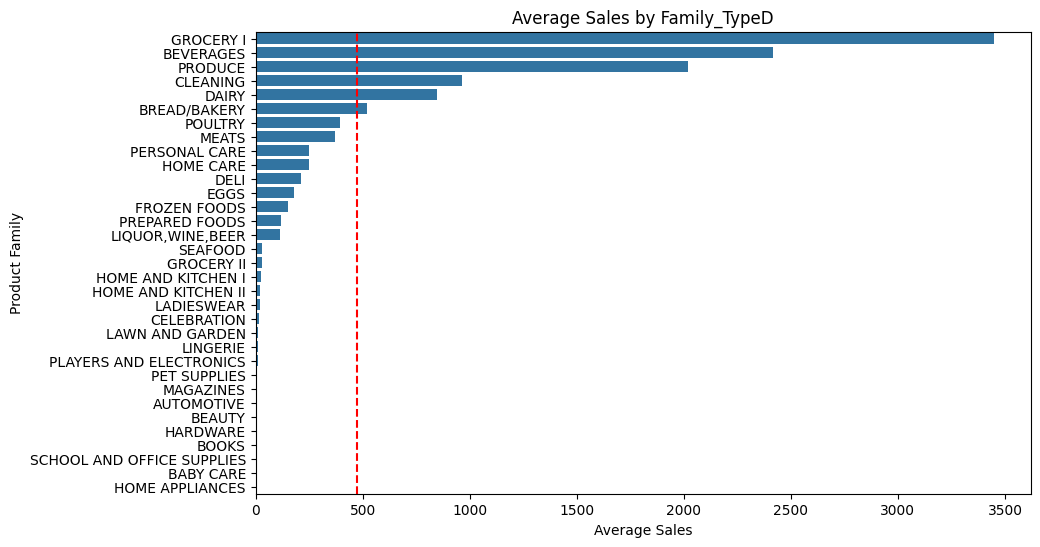

In [45]:
### 각 품목별로 매출에 미치는 영향

# 각 family 별로 'sales'의 평균을 계산하고, 내림차순으로 정렬
average_sales_by_family = typeD.groupby('family')['sales'].mean().sort_values(ascending=False)

## 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='sales', y='family', data=typeD, order=average_sales_by_family.index, ci=None)
plt.axvline(x=typeD['sales'].mean(), color='red', linestyle='--') # 매출 전체 평균

# 그래프 제목 및 레이블 설정
plt.title('Average Sales by Family_TypeD')
plt.xlabel('Average Sales')
plt.ylabel('Product Family')
plt.show()

- groceryI과 beverage가 매출의 대부분을 차지한다.
> 모델링 시 제품군을 one-hot encoding 후 반영하는 것이 좋을 것이라고 판단됨

### **💚 onpromotion**

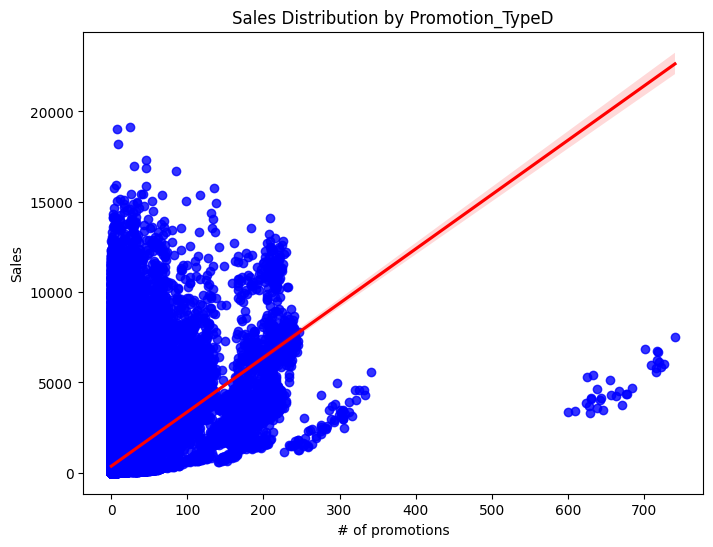

In [46]:
plt.figure(figsize=(8, 6))

sns.regplot(x='onpromotion', y='sales', data=typeD, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Promotion_TypeD')
plt.xlabel('# of promotions')
plt.ylabel('Sales')
plt.show()

- 약한 양의 상관관계를 보인다.
- promotion되는 제품 수와 상관 없이 매출액이 큰 경우들이 존재함을 확인할 수 있다.
- promotion 제품의 수가 적은데 sales가 높거나, promotion 제품의 수가 많은데 sales가 적은 경우들이 존재함.

### **💙 state**

In [47]:
# 고유한 주(state) 수

typeD['state'].unique()

array(['Santa Elena', 'El Oro', 'Pichincha', 'Azuay', 'Loja',
       'Santo Domingo de los Tsachilas', 'Tungurahua', 'Guayas', 'Manabi'],
      dtype=object)

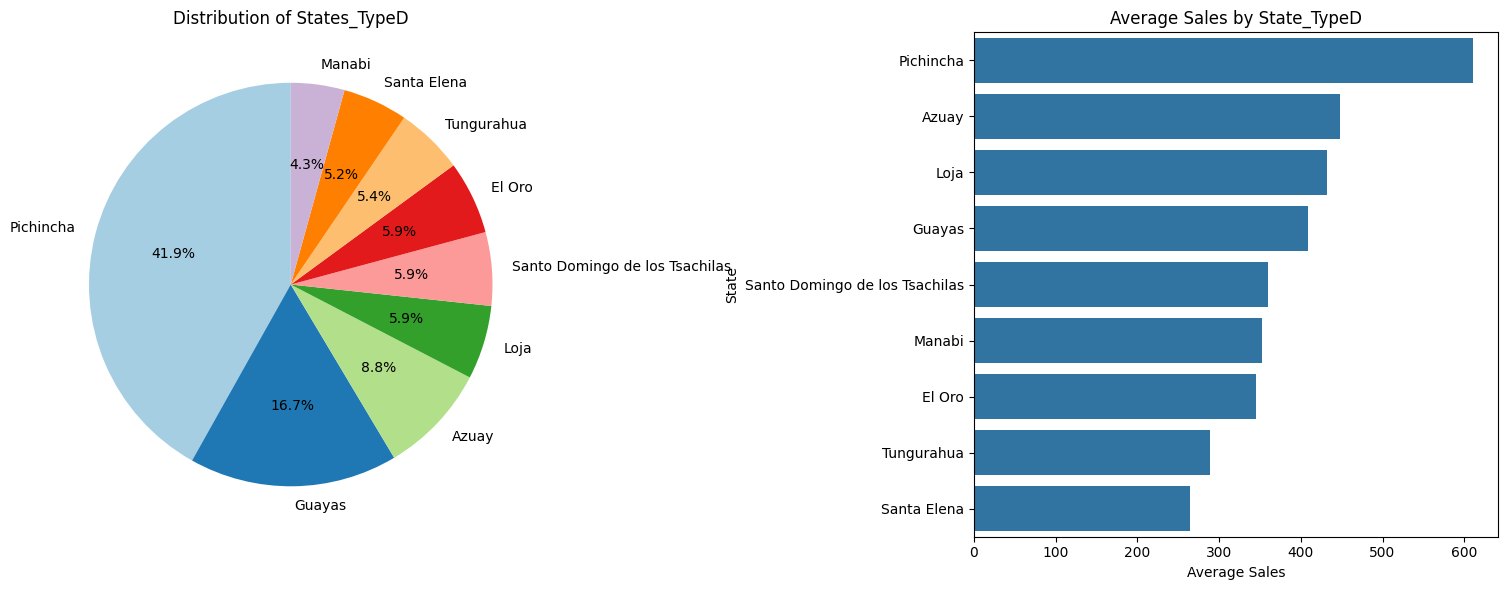

In [48]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
state_counts = typeD['state'].value_counts()
plt.pie(state_counts, labels=state_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of States_TypeD')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_state = typeD.groupby('state')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='state', data=typeD, order=average_sales_by_state.index, ci=None)

plt.title('Average Sales by State_TypeD')
plt.xlabel('Average Sales')
plt.ylabel('State')
plt.tight_layout()
plt.show()

- 주마다 매출액에 차이가 있음을 확인할 수 있다.
- Pichincha 주는 가장 많은 비율을 차지하면서 평균 매출도 가장 높다.
- (Azuay, Loja, Guayas), (Santo Domingo de los Tsachilas, Manabi, El Oro), ( Santa Elena, Tungurahua) 각 그룹 별로 매출이 비슷하다.

### **💜 city**

In [49]:
# 고유한 도시(city) 수

print(typeD.groupby('state')['store_nbr'].unique())
print()
print(typeD.groupby('state')['city'].unique())

state
Azuay                                          [37, 42]
El Oro                                             [41]
Guayas                                     [24, 27, 26]
Loja                                               [38]
Manabi                                             [53]
Pichincha                         [4, 6, 8, 7, 2, 1, 3]
Santa Elena                                        [25]
Santo Domingo de los Tsachilas                      [5]
Tungurahua                                         [23]
Name: store_nbr, dtype: object

state
Azuay                                       [Cuenca]
El Oro                                     [Machala]
Guayas                            [Guayaquil, Daule]
Loja                                          [Loja]
Manabi                                       [Manta]
Pichincha                                    [Quito]
Santa Elena                                [Salinas]
Santo Domingo de los Tsachilas       [Santo Domingo]
Tungurahua                  

- 대부분의 state에는 city가 하나씩만 존재한다.
- 'Guayas'주에만 도시가 'Guayaquil', 'Daule' 두 가지가 있다.


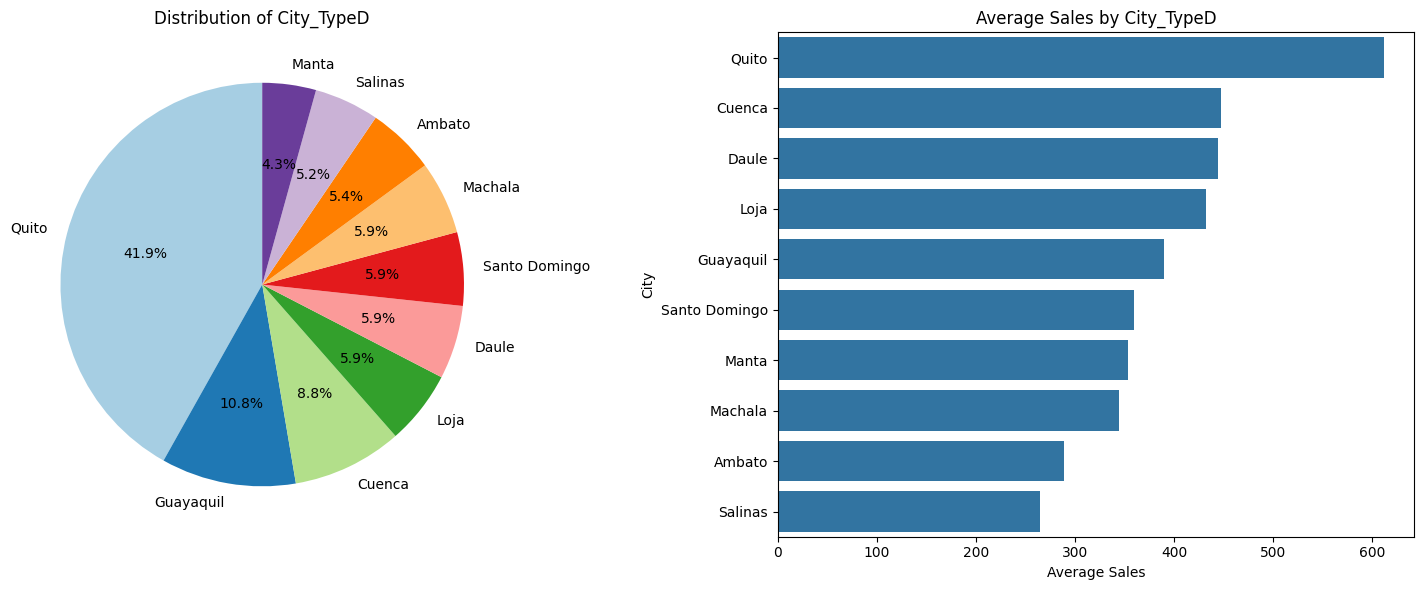

In [50]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
city_counts = typeD['city'].value_counts()
plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of City_TypeD')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_city = typeD.groupby('city')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='city', data=typeD, order=average_sales_by_city.index, ci=None)

plt.title('Average Sales by City_TypeD')
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.tight_layout()
plt.show()

- `state`를 통해 `city`가 다 구분되지 않는다.
  - 'Guayas'주만 도시가 'Guayaquil', 'Daule' 두 개로 나뉜다.
  - `state`로만 봤을 때는 'Guayas'가 평균 매출 4위였으나, `city`로 봤을 때는 'Daule'가 3위, 'Guayaquil'이 5위로 바뀐다.
  - `state` 대신 `city` 칼럼을 활용하기로 결정


### **🤎dcoilwtico**

In [51]:
import plotly.express as px
import plotly.graph_objects as go

daily_oil_price = typeD.groupby("date")["dcoilwtico"].mean().reset_index()
daily_sales = typeD.groupby("date")["sales"].mean().reset_index()

# 그래프 그리기
fig = go.Figure()
fig.add_trace(go.Scatter(x = daily_oil_price["date"], y=daily_oil_price["dcoilwtico"], name="Daily DcoilWTICO Prices"))
fig.add_trace(go.Scatter(x=daily_sales["date"], y=daily_sales["sales"], name="Daily Sales"))
fig.show()

- 유가 변동 경향과 sales의 변동이 별 상관은 없어 보인다.(추세가 다름)
- 2014년을 기점으로 급격하게 감소하는 추세를 보인다.
  - 그에 비해 매출은 그렇게 오르지 않았다.

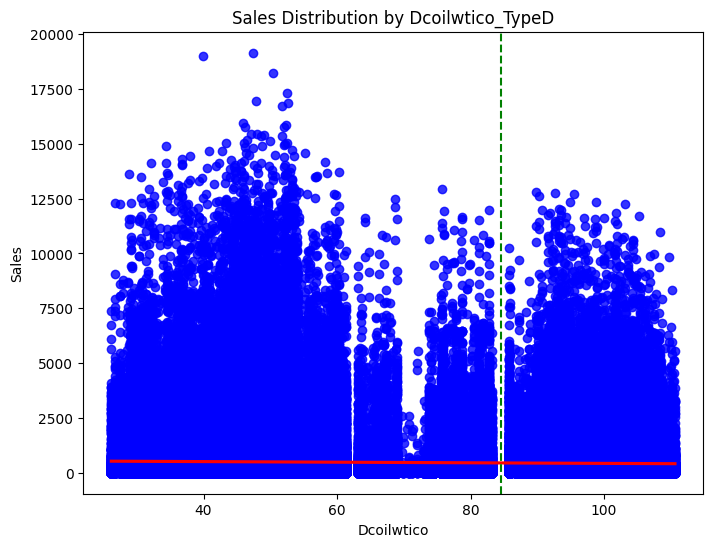

In [53]:
plt.figure(figsize=(8, 6))

sns.regplot(x='dcoilwtico', y='sales', data=typeD, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.axvline(x=84.5, color='green', linestyle='--') # 84.5 구분선

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Dcoilwtico_TypeD')
plt.xlabel('Dcoilwtico')
plt.ylabel('Sales')
plt.show()

- 큰 상관은 없어 보인다.
- 다만 유가가 **84.5** 전후에서 두 개의 그룹으로 확연히 분리되는 것을 확인할 수 있다.

In [54]:
under = typeD.loc[typeD['dcoilwtico'] <= 84.5,:]
over = typeD.loc[typeD['dcoilwtico'] > 84.5,:]

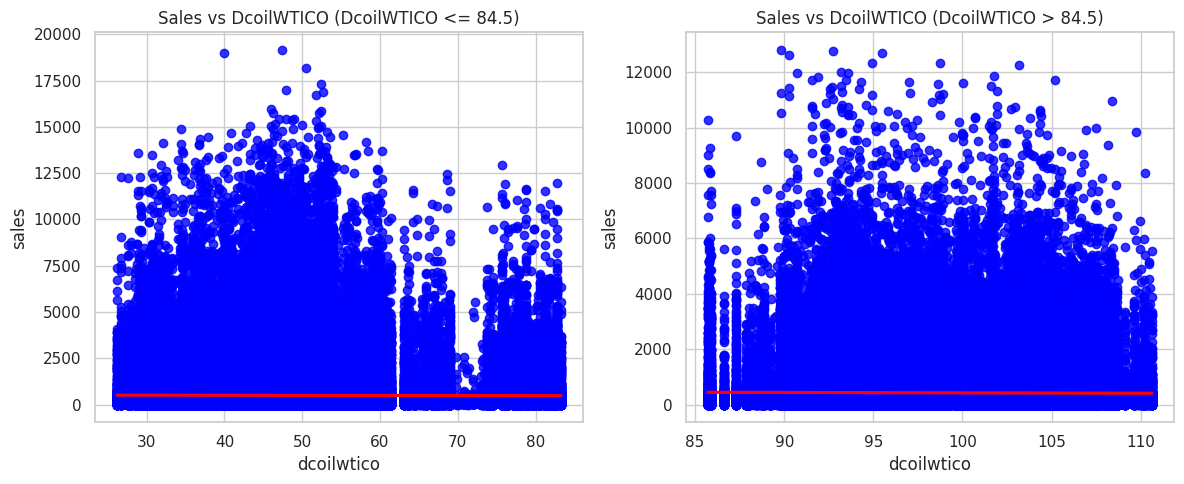

In [55]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot regplot for 'dcoilwtico' <= 84.5
sns.regplot(x='dcoilwtico', y='sales', data=under, ax=axes[0], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
axes[0].set_title('Sales vs DcoilWTICO (DcoilWTICO <= 84.5)')

# Plot regplot for 'dcoilwtico' > 84.5
sns.regplot(x='dcoilwtico', y='sales', data=over, ax=axes[1], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
axes[1].set_title('Sales vs DcoilWTICO (DcoilWTICO > 84.5)')

# Adjust layout
plt.tight_layout()
plt.show()

- 이상치를 제외하면 차이가 크지는 않다.
- 하지만 유가가 84.5 이상일 때는 sales가 14000이 넘는 경우가 아예 없는 반면, 유가가 84.5 이하일 때 sales가 14000이 넘는 경우가 다수 존재한다.
- 아주 유의미한 결과는 아니지만 유가에 따라 sales에 한도가 생길 수 있다고 생각할 수 있다.

### **💗 transactions**

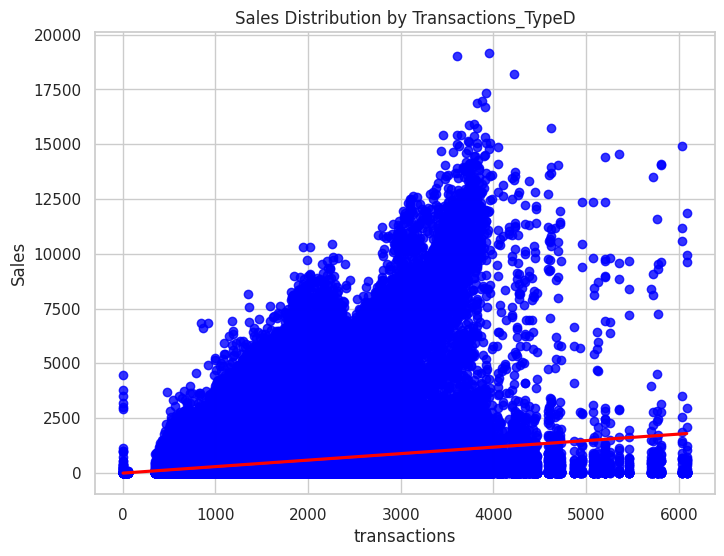

In [56]:
plt.figure(figsize=(8, 6))

sns.regplot(x='transactions', y='sales', data=typeD, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Transactions_TypeD')
plt.xlabel('transactions')
plt.ylabel('Sales')
plt.show()

- 약한 양의 상관관계를 보인다.

### **🤍 holiday**

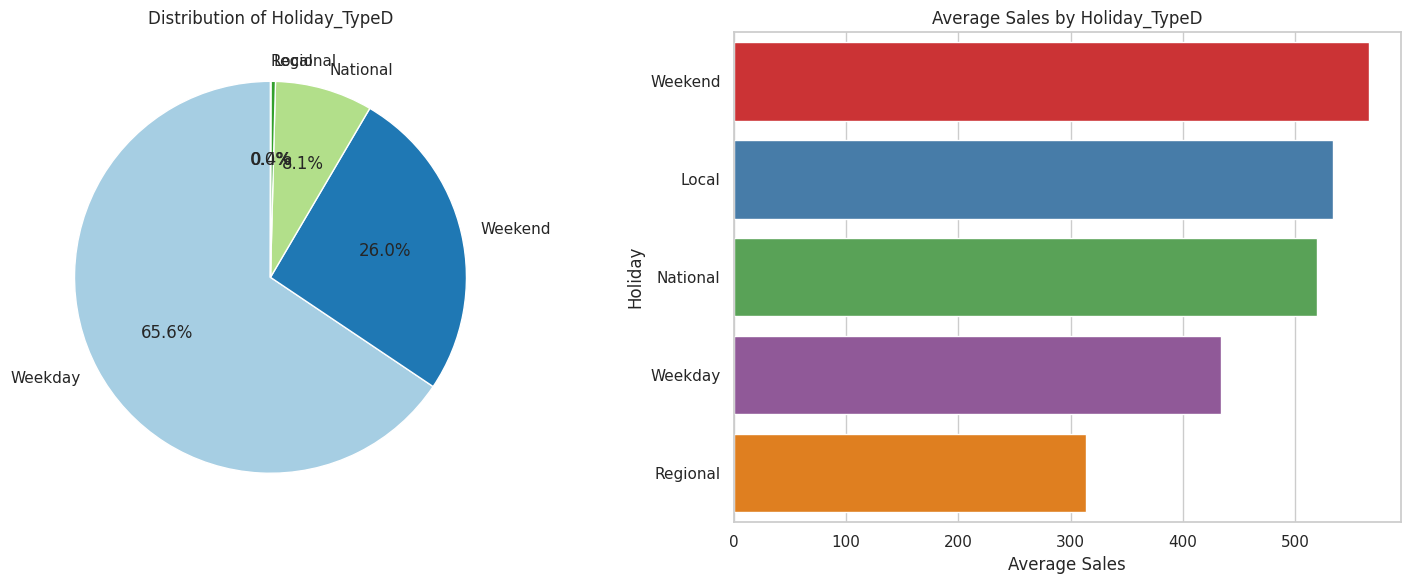

In [61]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
holiday_counts = typeD['holiday'].value_counts()
plt.pie(holiday_counts, labels=holiday_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Holiday_TypeD')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_holiday = typeD.groupby('holiday')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='holiday', data=typeD, order=average_sales_by_holiday.index, ci=None, palette = 'Set1')

plt.title('Average Sales by Holiday_TypeD')
plt.xlabel('Average Sales')
plt.ylabel('Holiday')
plt.tight_layout()
plt.show()

- 그냥 주말(공휴일은 제외됨)에 매출이 가장 좋다.

### **⭐Target 변수(Sales)**
- 여러 요인에 따라 매출이 어떻게 달라지는지 살펴보자.

#### **a) 시간 관련 변수**

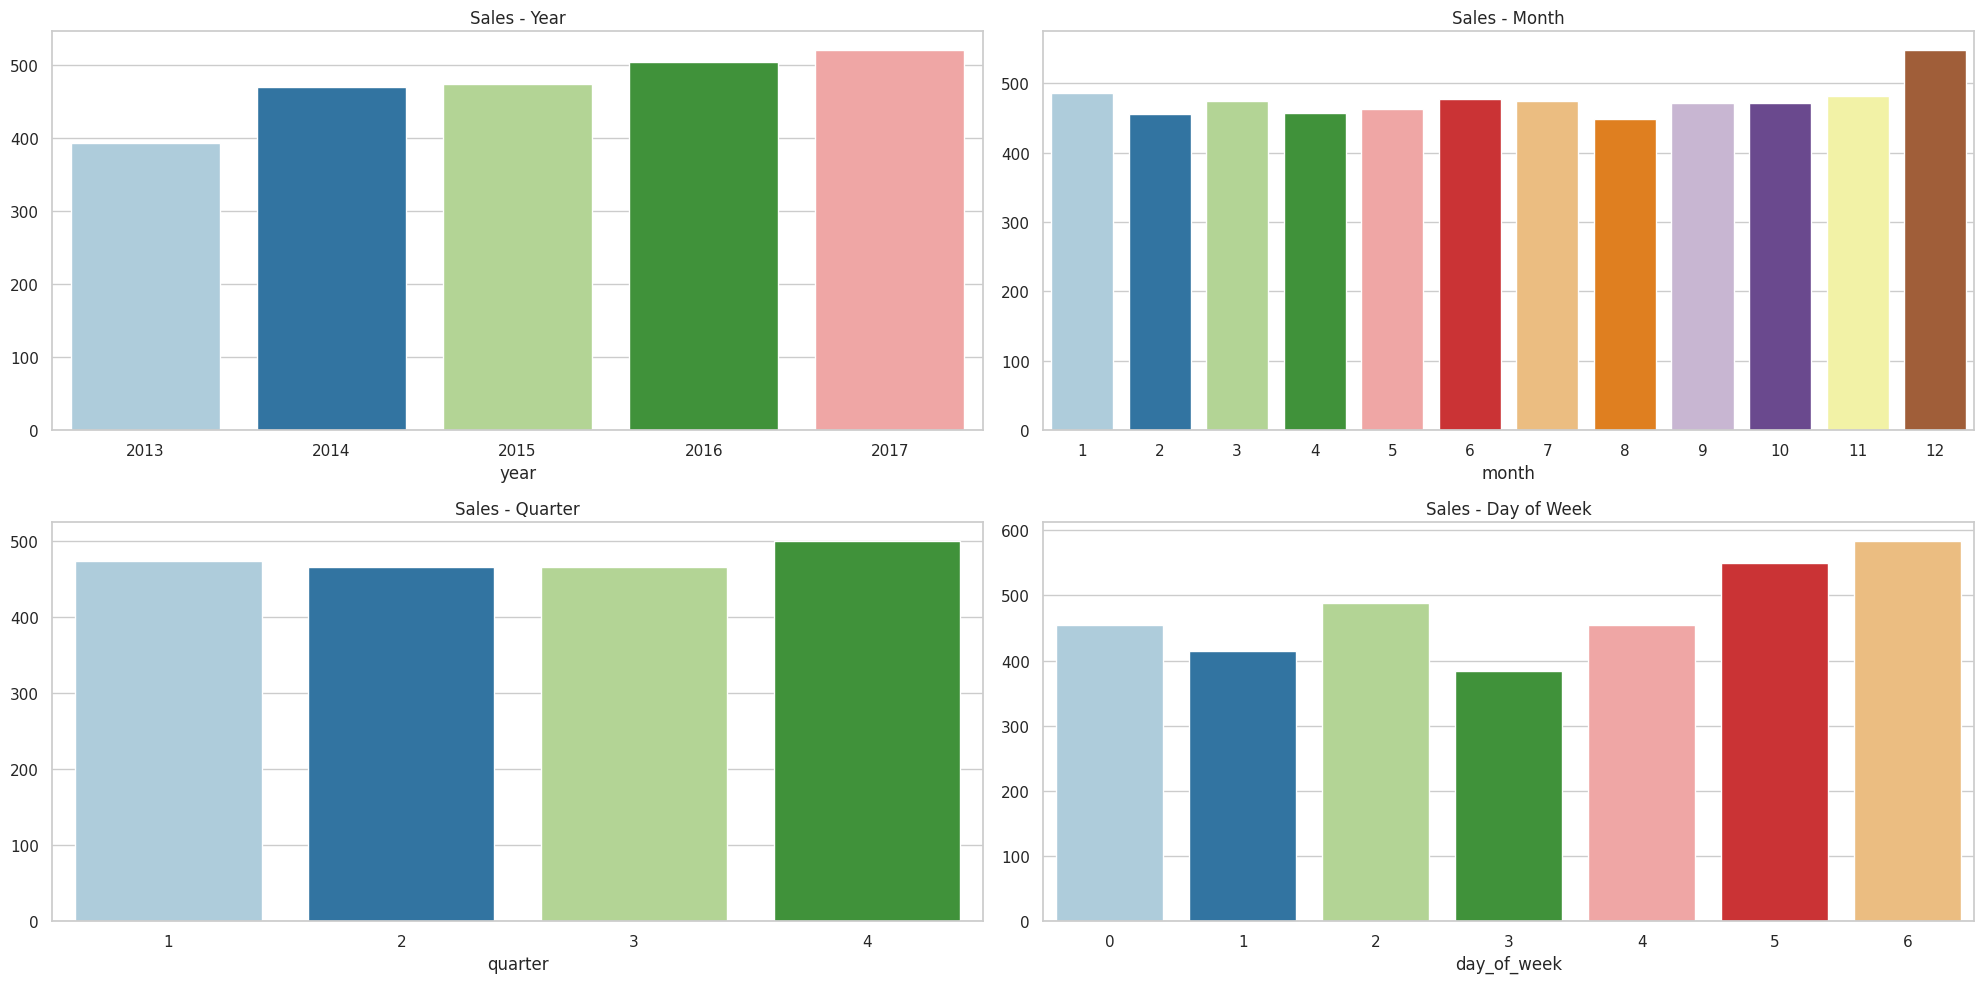

In [58]:
### 평균 매출액으로 시각화
data_grouped_year = typeD.groupby(['year']).mean()['sales']
data_grouped_month = typeD.groupby(['month']).mean()['sales']
data_grouped_quarter = typeD.groupby(['quarter']).mean()['sales']
data_grouped_day = typeD.groupby(['day_of_week']).mean()['sales']

palette = sns.color_palette("Paired")

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
# 연도별 매출
axes[0, 0].set_title('Sales - Year')
sns.barplot(x=data_grouped_year.index, y=data_grouped_year.values, ax=axes[0, 0], palette=palette)
# 월별 매출
axes[0, 1].set_title('Sales - Month')
sns.barplot(x=data_grouped_month.index, y=data_grouped_month.values, ax=axes[0, 1], palette=palette)
# 분기별 매출
axes[1, 0].set_title('Sales - Quarter')
sns.barplot(x=data_grouped_quarter.index, y=data_grouped_quarter.values, ax=axes[1, 0], palette=palette)
# 요일별 매출
axes[1, 1].set_title('Sales - Day of Week')
sns.barplot(x=data_grouped_day.index, y=data_grouped_day.values, ax=axes[1, 1], palette=palette)

plt.tight_layout()
plt.show()

**연도별 매출**
- 뒤로 갈수록 매출액이 점점 증가하고 있다.

**월별 & 분기별 매출**  
- 대체로 비슷한 경향을 보이나, 12월에 매출이 증가
- 4분기에 매출 증가

**요일별 매출**  
- 평일에 비해 주말의 매출액이 더 높다.

#### **b) 변수들 간의 상관관계**
- 상관계수는 수치형 변수들끼리만 비교 가능

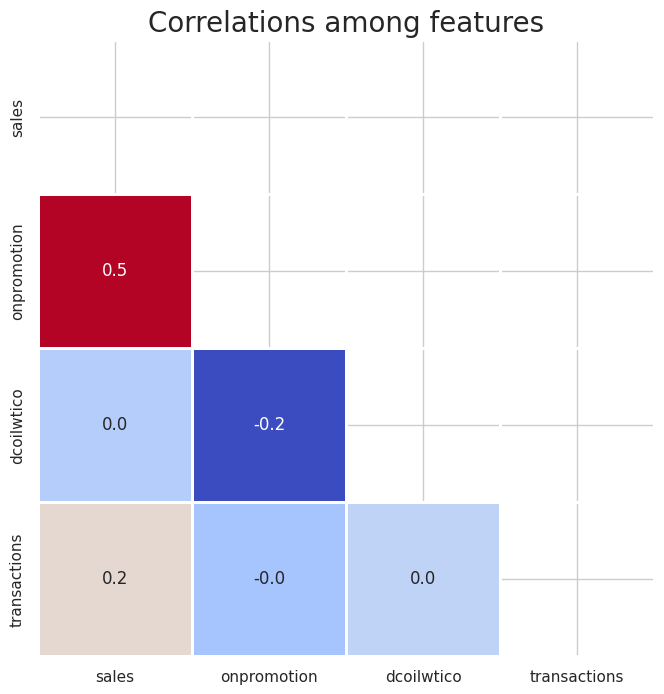

In [59]:
num_ftrs = typeD[['sales', 'onpromotion','dcoilwtico','transactions']]

mask = np.triu(num_ftrs.corr(method = 'spearman'))

# heatmap을 이용한 시각화
plt.figure(figsize=(8, 8))
sns.heatmap(num_ftrs.corr(method = 'spearman'),
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)
plt.title("Correlations among features", fontsize=20)
plt.show()

* sales와 유가의 상관계수는 무려 0이다.

* sales와 onpromotion의 상관계수는 0.5로 비교적 높은 편이다.

### **💡 후처리**

#### **최종 변수 선택**

In [62]:
typeD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727225 entries, 1427 to 2705085
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            727225 non-null  int64         
 1   date          727225 non-null  datetime64[ns]
 2   store_nbr     727225 non-null  int64         
 3   family        727225 non-null  object        
 4   sales         727225 non-null  float64       
 5   onpromotion   727225 non-null  float64       
 6   city          727225 non-null  object        
 7   state         727225 non-null  object        
 8   cluster       727225 non-null  int64         
 9   dcoilwtico    727225 non-null  float64       
 10  transactions  726107 non-null  float64       
 11  holiday       727225 non-null  object        
 12  year          727225 non-null  int64         
 13  quarter       727225 non-null  int64         
 14  month         727225 non-null  int64         
 15  day_of_week  

In [63]:
typeD = typeD[['store_nbr', 'family', 'sales', 'onpromotion', 'city', 'cluster', 'dcoilwtico', 'holiday', 'year', 'quarter', 'month', 'day_of_week']]

# test의 경우에는 이후 submission 파일 작성을 위해 일단 id를 남겨두기로 결정
typeD_te = typeD_te[['id', 'store_nbr', 'family', 'onpromotion', 'city', 'cluster', 'dcoilwtico', 'holiday', 'year', 'quarter', 'month', 'day_of_week']]

In [64]:
typeD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727225 entries, 1427 to 2705085
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   store_nbr    727225 non-null  int64  
 1   family       727225 non-null  object 
 2   sales        727225 non-null  float64
 3   onpromotion  727225 non-null  float64
 4   city         727225 non-null  object 
 5   cluster      727225 non-null  int64  
 6   dcoilwtico   727225 non-null  float64
 7   holiday      727225 non-null  object 
 8   year         727225 non-null  int64  
 9   quarter      727225 non-null  int64  
 10  month        727225 non-null  int64  
 11  day_of_week  727225 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 72.1+ MB


#### **Train/Validation Split**

In [65]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(typeD, test_size=0.3, random_state=42, stratify=typeD[['store_nbr', 'family']]) # 가게별 비율 유지

In [66]:
train.shape

(509057, 12)

In [67]:
val.shape

(218168, 12)

#### **변수 왜곡 정도 확인**

In [68]:
# 수치형 변수들에 대해서만 왜도 확인

train[['sales', 'onpromotion','dcoilwtico']].skew()

sales          4.41
onpromotion   11.35
dcoilwtico     0.61
dtype: float64

* sales와 onpromotion의 왜곡 정도가 매우 높음

In [69]:
train['sales'] = np.log1p(train['sales'])
train['onpromotion'] = np.log1p(train['onpromotion'])

In [70]:
train[['sales', 'onpromotion','dcoilwtico']].skew()

sales         0.08
onpromotion   2.14
dcoilwtico    0.61
dtype: float64

- 왜곡 정도가 많이 개선되었다.

In [71]:
val['onpromotion'] = np.log1p(val['onpromotion'])
typeD_te['onpromotion'] = np.log1p(typeD_te['onpromotion'])

#### **스케일링**
- 수치형 변수들에 대한 스케일링 진행

In [72]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected variables
train[['onpromotion', 'dcoilwtico']] = scaler.fit_transform(train[['onpromotion', 'dcoilwtico']])
val[['onpromotion', 'dcoilwtico']] = scaler.transform(val[['onpromotion', 'dcoilwtico']])
typeD_te[['onpromotion', 'dcoilwtico']] = scaler.transform(typeD_te[['onpromotion', 'dcoilwtico']])

In [73]:
train.head()

store_nbr      family  sales  onpromotion     city  cluster  \
1902173         53    HARDWARE   1.10         0.55    Manta       13   
1242020         41       MEATS   5.12        -0.52  Machala        4   
2674596          8  AUTOMOTIVE   2.20        -0.52    Quito        8   
2404174         27        DELI   5.38         1.38    Daule        1   
2491991          1   HOME CARE   3.81         0.83    Quito       13   

         dcoilwtico   holiday  year  quarter  month  day_of_week  
1902173       -0.77  National  2016        2      5            0  
1242020       -0.55   Weekday  2015        2      4            2  
2674596       -0.57   Weekend  2017        3      7            5  
2404174       -0.40   Weekday  2017        1      2            1  
2491991       -0.44  National  2017        2      4            4

In [74]:
val.head()

store_nbr           family  sales  onpromotion           city  \
554642          38    PERSONAL CARE 302.00        -0.52           Loja   
1956634          7  LAWN AND GARDEN   5.00        -0.52          Quito   
1859383         23     BREAD/BAKERY 265.48         0.15         Ambato   
2398272          5        HOME CARE 301.00         1.23  Santo Domingo   
2263327         26         CLEANING 362.00         1.91      Guayaquil   

         cluster  dcoilwtico  holiday  year  quarter  month  day_of_week  
554642         4        1.20  Weekday  2014        1      1            1  
1956634        8       -0.61  Weekday  2016        2      6            4  
1859383        9       -1.08  Weekday  2016        2      4            3  
2398272        4       -0.42  Weekend  2017        1      2            5  
2263327       10       -0.58  Weekday  2016        4     11            2

In [75]:
typeD_te.head()

id  store_nbr      family  onpromotion   city  cluster  dcoilwtico  \
0  3000888          1  AUTOMOTIVE        -0.52  Quito       13       -0.69   
1  3000889          1   BABY CARE        -0.52  Quito       13       -0.69   
2  3000890          1      BEAUTY         0.55  Quito       13       -0.69   
3  3000891          1   BEVERAGES         2.46  Quito       13       -0.69   
4  3000892          1       BOOKS        -0.52  Quito       13       -0.69   

   holiday  year  quarter  month  day_of_week  
0  Weekday  2017        3      8            2  
1  Weekday  2017        3      8            2  
2  Weekday  2017        3      8            2  
3  Weekday  2017        3      8            2  
4  Weekday  2017        3      8            2

#### **범주형 변수 처리**

In [76]:
train = pd.get_dummies(train, columns=['store_nbr','family', 'city', 'cluster', 'holiday', 'year', 'quarter', 'month', 'day_of_week'])
train.head()

sales  onpromotion  dcoilwtico  store_nbr_1  store_nbr_2  \
1902173   1.10         0.55       -0.77            0            0   
1242020   5.12        -0.52       -0.55            0            0   
2674596   2.20        -0.52       -0.57            0            0   
2404174   5.38         1.38       -0.40            0            0   
2491991   3.81         0.83       -0.44            1            0   

         store_nbr_3  store_nbr_4  store_nbr_5  store_nbr_6  store_nbr_7  \
1902173            0            0            0            0            0   
1242020            0            0            0            0            0   
2674596            0            0            0            0            0   
2404174            0            0            0            0            0   
2491991            0            0            0            0            0   

         store_nbr_8  store_nbr_23  store_nbr_24  store_nbr_25  store_nbr_26  \
1902173            0             0             0             0             0   
1242020            0             0             0             0             0   
2674596            1             0             0             0             0   
2404174            0             0             0             0             0   
2491991            0             0             0             0             0   

         store_nbr_27  store_nbr_37  store_nbr_38  store_nbr_41  store_nbr_42  \
1902173             0             0             0             0             0   
1242020             0             0             0             1             0   
2674596             0             0             0             0             0   
2404174             1             0             0             0             0   
2491991             0             0             0             0             0   

         store_nbr_53  family_AUTOMOTIVE  family_BABY CARE  family_BEAUTY  \
1902173             1                  0                 0              0   
1242020             0                  0                 0              0   
2674596             0                  1                 0              0   
2404174             0                  0                 0              0   
2491991             0                  0                 0              0   

         family_BEVERAGES  family_BOOKS  family_BREAD/BAKERY  \
1902173                 0             0                    0   
1242020                 0             0                    0   
2674596                 0             0                    0   
2404174                 0             0                    0   
2491991                 0             0                    0   

         family_CELEBRATION  family_CLEANING  family_DAIRY  family_DELI  \
1902173                   0                0             0            0   
1242020                   0                0             0            0   
2674596                   0                0             0            0   
2404174                   0                0             0            1   
2491991                   0                0             0            0   

         family_EGGS  family_FROZEN FOODS  family_GROCERY I  \
1902173            0                    0                 0   
1242020            0                    0                 0   
2674596            0                    0                 0   
2404174            0                    0                 0   
2491991            0                    0                 0   

         family_GROCERY II  family_HARDWARE  family_HOME AND KITCHEN I  \
1902173                  0                1                          0   
1242020                  0                0                          0   
2674596                  0                0                          0   
2404174                  0                0                          0   
2491991                  0                0                          0   

         family_HOME AND KITCHEN II  family_HO

In [77]:
val = pd.get_dummies(val, columns=['store_nbr','family', 'city', 'cluster', 'holiday', 'year', 'quarter', 'month', 'day_of_week'])
val.head()

sales  onpromotion  dcoilwtico  store_nbr_1  store_nbr_2  \
554642  302.00        -0.52        1.20            0            0   
1956634   5.00        -0.52       -0.61            0            0   
1859383 265.48         0.15       -1.08            0            0   
2398272 301.00         1.23       -0.42            0            0   
2263327 362.00         1.91       -0.58            0            0   

         store_nbr_3  store_nbr_4  store_nbr_5  store_nbr_6  store_nbr_7  \
554642             0            0            0            0            0   
1956634            0            0            0            0            1   
1859383            0            0            0            0            0   
2398272            0            0            1            0            0   
2263327            0            0            0            0            0   

         store_nbr_8  store_nbr_23  store_nbr_24  store_nbr_25  store_nbr_26  \
554642             0             0             0             0             0   
1956634            0             0             0             0             0   
1859383            0             1             0             0             0   
2398272            0             0             0             0             0   
2263327            0             0             0             0             1   

         store_nbr_27  store_nbr_37  store_nbr_38  store_nbr_41  store_nbr_42  \
554642              0             0             1             0             0   
1956634             0             0             0             0             0   
1859383             0             0             0             0             0   
2398272             0             0             0             0             0   
2263327             0             0             0             0             0   

         store_nbr_53  family_AUTOMOTIVE  family_BABY CARE  family_BEAUTY  \
554642              0                  0                 0              0   
1956634             0                  0                 0              0   
1859383             0                  0                 0              0   
2398272             0                  0                 0              0   
2263327             0                  0                 0              0   

         family_BEVERAGES  family_BOOKS  family_BREAD/BAKERY  \
554642                  0             0                    0   
1956634                 0             0                    0   
1859383                 0             0                    1   
2398272                 0             0                    0   
2263327                 0             0                    0   

         family_CELEBRATION  family_CLEANING  family_DAIRY  family_DELI  \
554642                    0                0             0            0   
1956634                   0                0             0            0   
1859383                   0                0             0            0   
2398272                   0                0             0            0   
2263327                   0                1             0            0   

         family_EGGS  family_FROZEN FOODS  family_GROCERY I  \
554642             0                    0                 0   
1956634            0                    0                 0   
1859383            0                    0                 0   
2398272            0                    0                 0   
2263327            0                    0                 0   

         family_GROCERY II  family_HARDWARE  family_HOME AND KITCHEN I  \
554642                   0                0                          0   
1956634                  0                0                          0   
1859383                  0                0                          0   
2398272                  0                0                          0   
2263327                  0                0                          0   

         family_HOME AND KITCHEN II  family_HO

In [78]:
train.shape

(509057, 104)

In [79]:
val.shape

(218168, 104)

- 103개의 feature 변수, 1개의 target 변수

In [80]:
typeD_te = pd.get_dummies(typeD_te, columns=['store_nbr','family', 'city', 'cluster', 'holiday', 'year', 'quarter', 'month', 'day_of_week'])
typeD_te.head()

id  onpromotion  dcoilwtico  store_nbr_1  store_nbr_2  store_nbr_3  \
0  3000888        -0.52       -0.69            1            0            0   
1  3000889        -0.52       -0.69            1            0            0   
2  3000890         0.55       -0.69            1            0            0   
3  3000891         2.46       -0.69            1            0            0   
4  3000892        -0.52       -0.69            1            0            0   

   store_nbr_4  store_nbr_5  store_nbr_6  store_nbr_7  store_nbr_8  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   store_nbr_23  store_nbr_24  store_nbr_25  store_nbr_26  store_nbr_27  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   store_nbr_37  store_nbr_38  store_nbr_41  store_nbr_42  store_nbr_53  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   family_AUTOMOTIVE  family_BABY CARE  family_BEAUTY  family_BEVERAGES  \
0                  1                 0              0                 0   
1                  0                 1              0                 0   
2                  0                 0              1                 0   
3                  0                 0              0                 1   
4                  0                 0              0                 0   

   family_BOOKS  family_BREAD/BAKERY  family_CELEBRATION  family_CLEANING  \
0             0                    0                   0                0   
1             0                    0                   0                0   
2             0                    0                   0                0   
3             0                    0                   0                0   
4             1                    0                   0                0   

   family_DAIRY  family_DELI  family_EGGS  family_FROZEN FOODS  \
0             0            0            0                    0   
1             0            0            0                    0   
2             0            0            0                    0   
3             0            0            0                    0   
4             0            0            0                    0   

   family_GROCERY I  family_GROCERY II  family_HARDWARE  \
0                 0                  0                0   
1                 0                  0                0   
2                 0                  0                0   
3                 0                  0                0   
4                 0                  0                0   

   family_HOME AND KITCHEN I  family_HOME AND KITCHEN II  \
0                          0                           0   
1                          0                           0   
2                          0                           0   
3                          0                           0   
4                          0                           0   

   family_HOME APPLIANCES  family_HOME CARE  family_LADIESWEAR  \
0                       0                 0                  0   
1                       0                 0              

In [81]:
typeD_te.shape

(9504, 84)

In [82]:
train.columns.difference(typeD_te.columns)

Index(['holiday_National', 'holiday_Regional', 'month_1', 'month_10',
       'month_11', 'month_12', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_9', 'quarter_1', 'quarter_2', 'quarter_4',
       'sales', 'year_2013', 'year_2014', 'year_2015', 'year_2016'],
      dtype='object')

- 차이가 나는 부분
  - holiday
  - year
  - quarter
  - month

In [83]:
## 변수 추가

typeD_te[['holiday_National', 'holiday_Regional', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2', 'quarter_4']] = 0

In [84]:
typeD_te.shape

(9504, 104)

In [85]:
train.columns.difference(typeD_te.columns)

Index(['sales'], dtype='object')

In [86]:
typeD_te.columns.difference(train.columns)

Index(['id'], dtype='object')

* id와 sales를 제외하고 모든 칼럼이 동일하게 들어감

In [87]:
# 최종 파일 저장

train.to_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/trainD.csv', index = False)
val.to_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/valD.csv', index = False)
typeD_te.to_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/testD.csv', index = False)